# Plotting blocking features for nextGEMS

In [1]:
%matplotlib inline
from contrack import contrack
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys, os, argparse
import seaborn as sns

import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib.patches import Polygon

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.feature as cfeature

#filters and units
from scipy.ndimage import gaussian_filter
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import norm as stats_norm
from scipy.stats import mannwhitneyu, entropy

from statsmodels.stats.multitest import fdrcorrection
import cartopy.util as cutil

import glob
import pandas as pd

sys.path.append('/home/b/b382006/tools/util')
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#import bottleneck
#import dask.diagnostics
#dask.diagnostics.ProgressBar().register()

In [2]:
def calc_agree(ensamble, cli):
    ############################
    ##===========Calculate diagreement
    #########################
    bias = ensamble - cli
    
    percent = 80
    threshold = percent / 100
    
    # Calculate the fraction of values greater than 0 and less than 0 along the first axis
    count1 = np.sum(bias > 0, axis=0) / bias.shape[0]
    count2 = np.sum(bias < 0, axis=0) / bias.shape[0]
    
    # Create the binary matrix where the condition is met
    binary = np.logical_or(count1 > threshold, count2 > threshold).astype(int)

    print("Calculated disagree")
    return binary

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())


def compare_blocking_frequency(da1, da2, alpha=0.05):
    """
    Compare blocking frequencies between two datasets using a z-test for proportions.
    
    Parameters:
    ----------
    da1, da2 : xarray.DataArray
        Binary arrays (0 = no blocking, 1 = blocking) with dimensions (time, lat, lon)
    alpha : float
        Significance level (default 0.05)
    
    Returns:
    -------
    pval_da : xarray.DataArray
        p-values of the z-test at each grid point
    sig_mask : xarray.DataArray
        Binary mask (1 = significant difference, 0 = not significant)
    freq_diff : xarray.DataArray
        Difference in blocking frequency: da1 - da2
    """
    
    # Ensure matching dimensions
    if da1.shape != da2.shape:
        raise ValueError("Input arrays must have the same shape and coordinates.")
    
    # Sample size (time dimension)
    n = da1.shape[0]

    # Sum of blocking events
    x1 = da1.sum(dim="time").values
    x2 = da2.sum(dim="time").values

    # Proportions
    p1 = x1 / n
    p2 = x2 / n

    # Pooled proportion and standard error
    p_pool = (x1 + x2) / (2 * n)
    se = np.sqrt(2 * p_pool * (1 - p_pool) / n)
    se = np.where(se == 0, np.nan, se)  # Avoid division by zero

    # Z-score and p-values
    z = (p1 - p2) / se
    pvals = 2 * (1 - stats_norm.cdf(np.abs(z)))

    # Significance mask
    mask = np.where(pvals < alpha, 1, 0)

    # Frequency difference
    freq_diff = p1 - p2

    # Convert to xarray
    coords = {"lat": da1.lat, "lon": da1.lon}
    dims = ("lat", "lon")

    pval_da = xr.DataArray(pvals, coords=coords, dims=dims, name="p_value")
    sig_mask = xr.DataArray(mask, coords=coords, dims=dims, name="significance_mask")
    freq_diff_da = xr.DataArray(freq_diff, coords=coords, dims=dims, name="frequency_difference")

    return pval_da, sig_mask, freq_diff_da


def compare_blocking_frequency_unequal(da1, da2, alpha=0.05):
    """
    Compare blocking frequency between two binary (0/1) datasets using
    a z-test for difference in proportions with unequal sample sizes.

    Parameters:
    ----------
    da1, da2 : xarray.DataArray
        Binary arrays with shape (time, lat, lon)
    alpha : float
        Significance level (default 0.05)

    Returns:
    -------
    pval_da : xarray.DataArray
        p-values of the z-test
    sig_mask : xarray.DataArray
        Binary mask where 1 = significant difference
    freq_diff : xarray.DataArray
        Difference in blocking frequency: da1 - da2
    """

    # Check matching spatial dimensions
    if da1.shape[1:] != da2.shape[1:]:
        raise ValueError("Spatial dimensions (lat/lon) must match between datasets.")
    
    # Number of time steps
    n1 = da1.shape[0]
    n2 = da2.shape[0]

    # Sum of blocking events at each grid point
    x1 = da1.sum(dim="time").values
    x2 = da2.sum(dim="time").values

    # Proportions
    p1 = x1 / n1
    p2 = x2 / n2

    # Pooled proportion and standard error
    p_pool = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    se = np.where(se == 0, np.nan, se)  # avoid divide-by-zero

    # Z-score and p-values
    z = (p1 - p2) / se
    pvals = 2 * (1 - stats_norm.cdf(np.abs(z)))

    # Frequency difference
    freq_diff = p1 - p2

    # Significance mask
    mask = np.where(pvals < alpha, 1, 0)

    # Coordinates
    coords = {"lat": da1.lat, "lon": da1.lon}
    dims = ("lat", "lon")

    # Convert to xarray
    pval_da = xr.DataArray(pvals, coords=coords, dims=dims, name="p_value")
    sig_mask = xr.DataArray(mask, coords=coords, dims=dims, name="significance_mask")
    freq_diff_da = xr.DataArray(freq_diff, coords=coords, dims=dims, name="frequency_difference")

    return pval_da, sig_mask, freq_diff_da


def apply_fdr(pval_da, alpha=0.05):
    """
    Apply FDR correction (Benjamini-Hochberg) to an xarray DataArray of p-values.

    Parameters:
    ----------
    pval_da : xarray.DataArray
        2D DataArray of raw p-values (lat, lon)
    alpha : float
        FDR significance level (e.g., 0.05)

    Returns:
    -------
    adj_pvals : xarray.DataArray
        Adjusted p-values after FDR correction (same shape as input)
    fdr_mask : xarray.DataArray
        Binary significance mask (1 = significant after FDR, 0 = not)
    """

    # Flatten the 2D p-value array while keeping coordinates
    p_flat = pval_da.stack(points=("lat", "lon"))
    
    # Drop NaNs before applying FDR
    valid = ~np.isnan(p_flat)
    pvals = p_flat[valid].values

    # Apply FDR correction
    rejected, pvals_adj = fdrcorrection(pvals, alpha=alpha, method='indep')

    # Reconstruct full array with adjusted p-values
    pval_adj_full = xr.full_like(p_flat, np.nan)
    pval_adj_full.values[valid] = pvals_adj

    # Unstack to restore original shape
    adj_pvals = pval_adj_full.unstack("points").rename("pval_fdr_adjusted")

    # Create binary mask for significant results
    fdr_mask = xr.where(adj_pvals < alpha, 1, 0).astype(int).rename("fdr_significance_mask")

    return adj_pvals, fdr_mask

In [3]:
def compute_significant_v1(era5, block_ifs, n_bootstrap=500, sample_years=5, sig_level=0.05):
    """
    Compute a significance mask for bias using bootstrapping.

    Parameters:
    - era5 (xarray.DataArray): ERA5 dataset with time dimension.
    - block_ifs (xarray.DataArray): Model data (IFS ensemble mean).
    - n_bootstrap (int): Number of bootstrap samples (default=500).
    - sample_years (int): Number of random years per bootstrap sample (default=5).
    - sig_level (float): Significance level (default=0.05 for 95% confidence).

    Returns:
    - xarray.DataArray: Boolean mask where biases are significant.
    """
    
    # Generate bootstrap samples (randomly select 'sample_years' from the available era5 years)
    available_years = np.unique(era5.time.dt.year.values)
    random_years = np.random.choice(available_years, size=(n_bootstrap, sample_years), replace=True)

    # Compute bootstrap biases
    bootstrap_biases = []
    for years in random_years:
        sampled_era5 = era5.sel(time=np.isin(era5.time.dt.year, years))
        sampled_era5 = xr.where(sampled_era5['flag']>1,1,0).mean(dim='time')*100  
        bootstrap_biases.append(block_ifs - sampled_era5)
    
    # Convert to xarray for easy processing
    bootstrap_biases = xr.concat(bootstrap_biases, dim="bootstrap")

    # Compute percentile thresholds
    lower_bound = bootstrap_biases.quantile(sig_level, dim="bootstrap")
    upper_bound = bootstrap_biases.quantile(1 - sig_level, dim="bootstrap")

    ### compute actual bias    
    block_era5 = era5.sel(time=slice('2015', '2019'))
    block_era5 = xr.where(block_era5['flag']>1,1,0).mean(dim='time')*100     
    block_bias_ifs=block_ifs- block_era5

    # Determine significant grid points
    significant_mask = (  block_bias_ifs > upper_bound) | \
                       (  block_bias_ifs < lower_bound)

    return significant_mask

def compute_significant_v2(era5, block_ifs, n_bootstrap=500, sample_years=5, sig_level=0.05):
    """
    Compute a significance mask for bias using bootstrapping.

    Parameters:
    - era5 (xarray.DataArray): ERA5 dataset with time dimension.
    - block_ifs (xarray.DataArray): Model data (IFS ensemble mean).
    - n_bootstrap (int): Number of bootstrap samples (default=500).
    - sample_years (int): Number of random years per bootstrap sample (default=5).
    - sig_level (float): Significance level (default=0.05 for 95% confidence).

    Returns:
    - xarray.DataArray: Boolean mask where biases are significant.
    """
    
    # Generate bootstrap samples (randomly select 'sample_years' from the available era5 years)
    available_years = np.unique(era5.time.dt.year.values)
    random_years = np.random.choice(available_years, size=(n_bootstrap, sample_years), replace=True)

    # Compute bootstrap biases
    bootstrap_biases = []
    for years in random_years:
        sampled_era5 = era5.sel(time=np.isin(era5.time.dt.year, years))
        sampled_era5 = xr.where(sampled_era5['flag']>1,1,0).mean(dim='time')*100  
        bootstrap_biases.append(block_ifs - sampled_era5)
    
    # Convert to xarray for easy processing
    bootstrap_biases = xr.concat(bootstrap_biases, dim="bootstrap")

    ### compute actual bias    
    block_era5 = era5.sel(time=slice('2015', '2019'))
    block_era5 = xr.where(block_era5['flag']>1,1,0).mean(dim='time')*100     
    block_bias_ifs=block_ifs- block_era5
    
    # Expand the observed field to have the same "iteration" dimension for comparison
    obs_expanded = block_bias_ifs.expand_dims(bootstrap=bootstrap_biases.bootstrap)
    
    # For each grid cell, compute the fraction of iterations where |MC| >= |Observed|
    p_field = (np.abs(bootstrap_biases) >= np.abs(obs_expanded)).sum(dim="bootstrap") / bootstrap_biases.sizes["bootstrap"]

    # Determine significant grid points
    significant_mask = (p_field < sig_level).astype(int)

    return significant_mask

def compute_significant_v3(era5, block_ifs, n_bootstrap=100, sample_years=5, sig_level=0.05):
    """
    Compute a significance mask for bias using bootstrapping.

    Parameters:
    - era5 (xarray.DataArray): ERA5 dataset with time dimension.
    - block_ifs (xarray.DataArray): Model data (IFS ensemble mean).
    - n_bootstrap (int): Number of bootstrap samples (default=500).
    - sample_years (int): Number of random years per bootstrap sample (default=5).
    - sig_level (float): Significance level (default=0.05 for 95% confidence).

    Returns:
    - xarray.DataArray: Boolean mask where biases are significant.
    """
    
    # Generate bootstrap samples (randomly select 'sample_years' from the available era5 years)
    available_years = np.unique(era5.time.dt.year.values)
    random_years = np.random.choice(available_years, size=(n_bootstrap, sample_years), replace=True)

    # Compute bootstrap biases
    bootstrap_biases = []
    for years in random_years:
        sampled_era5 = era5.sel(time=np.isin(era5.time.dt.year, years))
        sampled_era5 = xr.where(sampled_era5['flag']>1,1,0).mean(dim='time')*100  
        bootstrap_biases.append(block_ifs - sampled_era5)
    
    # Convert to xarray for easy processing
    bootstrap_biases = xr.concat(bootstrap_biases, dim="bootstrap")

    ### compute actual bias    
    block_era5 = era5.sel(time=slice('2015', '2019'))
    block_era5 = xr.where(block_era5['flag']>1,1,0).mean(dim='time')*100     
    block_bias_ifs=block_ifs- block_era5
    
# Concatenate the actual bias to the bootstrap biases along a new 'bootstrap' dimension
    all_biases = xr.concat([bootstrap_biases, block_bias_ifs.expand_dims("bootstrap")], dim="bootstrap")

# Compute the rank of the actual bias within the 501 samples (rank starts from 1)
    ranks = all_biases.rank(dim="bootstrap", pct=False)  

# Extract the rank of the actual bias (the last entry in the bootstrap dimension)
    bias_rank = ranks.sel(bootstrap=n_bootstrap)  # Since we appended at the end

# Compute the two-sided p-value using the provided formula
    p_values = 2 * ((n_bootstrap / 2) - abs(bias_rank - ((n_bootstrap / 2) + 1))) / (n_bootstrap + 1)

    # Determine significant grid points
    significant_mask = (p_values < sig_level).astype(int)

    return significant_mask

def arc_coords(center_lat, center_lon, radius_deg, start_angle, end_angle, n_points=200):
    theta = np.radians(np.linspace(start_angle, end_angle, n_points))
    lats = center_lat + radius_deg * np.sin(theta)
    lons = center_lon + radius_deg * np.cos(theta)
    return lons, lats

# Semi-circle function (for polar views)
def draw_semicircle(ax, center_lat, radius_deg, lon_start, lon_end, color, **kwargs):
    """
    Draws a semi-circle around the pole in a stereographic projection.
    
    Parameters:
        ax: cartopy GeoAxes
        center_lat: latitude of the center (e.g., 90 for NH)
        radius_deg: angular radius in degrees from the pole
        lon_start, lon_end: longitude bounds (e.g., -90 to 90)
        color: line color
        kwargs: additional matplotlib plot keyword args
    """
    # Generate angles for arc
    lons = np.linspace(lon_start, lon_end, 300)
    lats = np.full_like(lons, center_lat - radius_deg)
    
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), color=color, **kwargs)

In [4]:
#### Working on signicance for climate change
def block_bootstrap_frequency_diff(da1, da2, block_size=5, n_bootstrap=1000, alpha=0.05):
    """
    Block bootstrap test for difference in blocking frequency between two binary arrays.

    Parameters:
    ----------
    da1, da2 : xarray.DataArray
        Binary (0/1) arrays with shape (time, lat, lon)
    block_size : int
        Length of time blocks to sample (e.g. 5 days)
    n_bootstrap : int
        Number of bootstrap samples
    alpha : float
        Significance level

    Returns:
    -------
    pval_da : xarray.DataArray
        Bootstrap p-values
    sig_mask : xarray.DataArray
        Significance mask (1 if significant)
    freq_diff_da : xarray.DataArray
        Observed frequency difference (da1 - da2)
    """

    n1, n2 = da1.shape[0], da2.shape[0]
    time_len = min(n1, n2)  # limit to common length for fair comparison

    # Trim to same time length
    da1 = da1.isel(time=slice(0, time_len))
    da2 = da2.isel(time=slice(0, time_len))

    # Original frequency difference
    freq1 = da1.mean(dim="time").values
    freq2 = da2.mean(dim="time").values
    freq_diff_obs = freq1 - freq2

    # Prepare bootstrap
    n_blocks = time_len // block_size
    block_indices = np.arange(n_blocks)
    time_indices = np.arange(time_len)

    bootstrap_diffs = np.empty((n_bootstrap,) + freq_diff_obs.shape)

    for i in range(n_bootstrap):
        # Sample blocks with replacement
        block_starts = np.random.choice(block_indices, size=n_blocks, replace=True) * block_size
        resampled_idx = np.concatenate([np.arange(s, s + block_size) for s in block_starts])
        resampled_idx = resampled_idx[resampled_idx < time_len]  # in case of overflow

        # Resample and compute frequency
        boot1 = da1.isel(time=resampled_idx).mean(dim="time").values
        boot2 = da2.isel(time=resampled_idx).mean(dim="time").values
        bootstrap_diffs[i] = boot1 - boot2

    # Compute p-values
    pvals = np.mean(np.abs(bootstrap_diffs) >= np.abs(freq_diff_obs), axis=0)

    # Significance mask
    sig_mask = (pvals < alpha).astype(int)

    # Convert to xarray
    coords = {"lat": da1.lat, "lon": da1.lon}
    dims = ("lat", "lon")

    pval_da = xr.DataArray(pvals, coords=coords, dims=dims, name="p_value")
    sig_da = xr.DataArray(sig_mask, coords=coords, dims=dims, name="significance_mask")
    freq_diff_da = xr.DataArray(freq_diff_obs, coords=coords, dims=dims, name="frequency_difference")

    return pval_da, sig_da, freq_diff_da


In [5]:
####
# Converts a CPT file to be used in Python
cpt = loadCPT('/home/b/b382006/tools/util/BlueWhiteOrangeRed.cpt')
# Makes a linear interpolation
cpt_convert = LinearSegmentedColormap('cpt', cpt)

# Resolution check with IFS Cycle 3/4

In [6]:
###
### Compute mean frequency
sufix='JJA' ### YEAR, DJF, JJA
## Hemisphere
hemisphere='NH' ### NH, SH

In [7]:
### ERA5
era5_z500_day=xr.open_dataset("/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.nc")

era5_z500_day=era5_z500_day.rename({'latitude':'lat'})
era5_z500_day=era5_z500_day.rename({'longitude':'lon'})

###
era5_z500_day['lon']=era5_z500_day['lon']+180
era5_z500_day=era5_z500_day.roll(lon=180)

In [8]:
###=== ERA5 
if sufix =='YEAR':
    blocks_era5=era5_z500_day
if sufix =='DJF':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([6, 7, 8]))
    
### accumulate 
##take only last five years
acc_era5=blocks_era5.sel(time=slice('2015','2019'))
acc_era5 = xr.where(acc_era5['flag']>1,1,0).mean(dim='time')*100

In [9]:
#era5_z500_day['flag'][100,...].plot()

In [10]:
### dictonary with models #"IFS_28-FESOM_25-cycle3" #"IFS_9-NEMO_25-cycle3"  #"IFS_4.4-FESOM_5-cycle3"
models=[
    "IFS_4.4-FESOM_5-cycle3",
    "IFS_9-NEMO_25-cycle3",
    "IFS_28-NEMO_25-cycle3",
    "IFS_28-FESOM_25-cycle3",
    ]


inpath='/scratch/b/b382006/nextgems/cycle3'

query = dict(
    source_id=models,  #Only choosing one model here
    )
block_ifs=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    tmp = xr.open_dataset(inpath+'/'+sid+"/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc")
    print(sid,inpath+'/'+sid+"/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc")
    
### select period
    if sufix =='YEAR':
        tmp = tmp
    if sufix =='DJF':
        tmp = tmp.sel(time=tmp.time.dt.month.isin([1, 2, 12]))
    if sufix =='JJA':
        tmp = tmp.sel(time=tmp.time.dt.month.isin([6, 7, 8]))

    ### accumulate 
    acc_tmp = xr.where(tmp['flag']>1,1,0).mean(dim='time')*100
    
    block_ifs.append(acc_tmp)
    
### Add IFS historical and take 5 years to compare
#ifs_c4=xr.open_dataset("/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_Z500_90th/BLOCKS-ifs-production-1990-2019.nc")
#ifs_c4=ifs_c4.sel(time=slice('2015','2019'))
ifs_c4=xr.open_dataset("/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.nc")
ifs_c4=ifs_c4.sel(time=slice('2020','2024'))

print("IFS_9-FESOM_5-cycle4","/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.nc")

### select period
if sufix =='YEAR':
    tmp = ifs_c4
if sufix =='DJF':
    tmp = ifs_c4.sel(time=ifs_c4.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    tmp = ifs_c4.sel(time=ifs_c4.time.dt.month.isin([6, 7, 8]))

    ### accumulate
acc_tmp = xr.where(tmp['flag']>1,1,0).mean(dim='time')*100
acc_tmp['lon']=acc_tmp['lon']+180
acc_tmp=acc_tmp.roll(lon=180)

block_ifs.append(acc_tmp)

#concatening
block_ifs_ens=xr.concat(block_ifs, "model")
#block_ifs_ens

IFS_4.4-FESOM_5-cycle3 /scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc
IFS_9-NEMO_25-cycle3 /scratch/b/b382006/nextgems/cycle3/IFS_9-NEMO_25-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc
IFS_28-NEMO_25-cycle3 /scratch/b/b382006/nextgems/cycle3/IFS_28-NEMO_25-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc
IFS_28-FESOM_25-cycle3 /scratch/b/b382006/nextgems/cycle3/IFS_28-FESOM_25-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.nc
IFS_9-FESOM_5-cycle4 /scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.nc


In [11]:
### bias and model comparison against 4.4 km
bias_block_ens = block_ifs_ens - acc_era5 ### abs
bias_block_rel = (block_ifs_ens - acc_era5) /acc_era5 *1e2 ### relative

###model difference
sims_diff_28km_fesom = block_ifs_ens[0,...] - block_ifs_ens[3,...]
sims_diff_28km_fesom_rel = (block_ifs_ens[0,...] - block_ifs_ens[3,...]) / block_ifs_ens[3,...] *1e2 ### relative
#sims_diff_9km_fesom = block_ifs_ens[0,...] - block_ifs_ens[4,...]

### significance
significant_4km = compute_significant_v3(blocks_era5, block_ifs_ens[0,...])
significant_9km = compute_significant_v3(blocks_era5, block_ifs_ens[4,...])
significant_28km = compute_significant_v3(blocks_era5, block_ifs_ens[3,...])



#### filters
### BIAS mean ensamble
acc_era5_fil = gaussian_filter(acc_era5, sigma=1)
acc_era5_new, clon = cutil.add_cyclic(acc_era5_fil, acc_era5.lon)

###
#block_cmip6_ens.isel(model=7).plot()
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

# Ensure proper slicing order for latitude
era5_lat_slice = acc_era5.sel(lat=slice(90, 0))

# Calculate RMSE for all ensemble members
rmse_ifs_values = [
    rmse(block_ifs_ens[i, ...].sel(lat=slice(0, 90)), era5_lat_slice)
    for i in range(4)
]

# Calculate the RMSE
print('IFS: ', rmse_ifs_values)

IFS:  [<xarray.DataArray 'flag' ()>
array(2.28117332), <xarray.DataArray 'flag' ()>
array(2.14131577), <xarray.DataArray 'flag' ()>
array(2.08155803), <xarray.DataArray 'flag' ()>
array(2.16477848)]


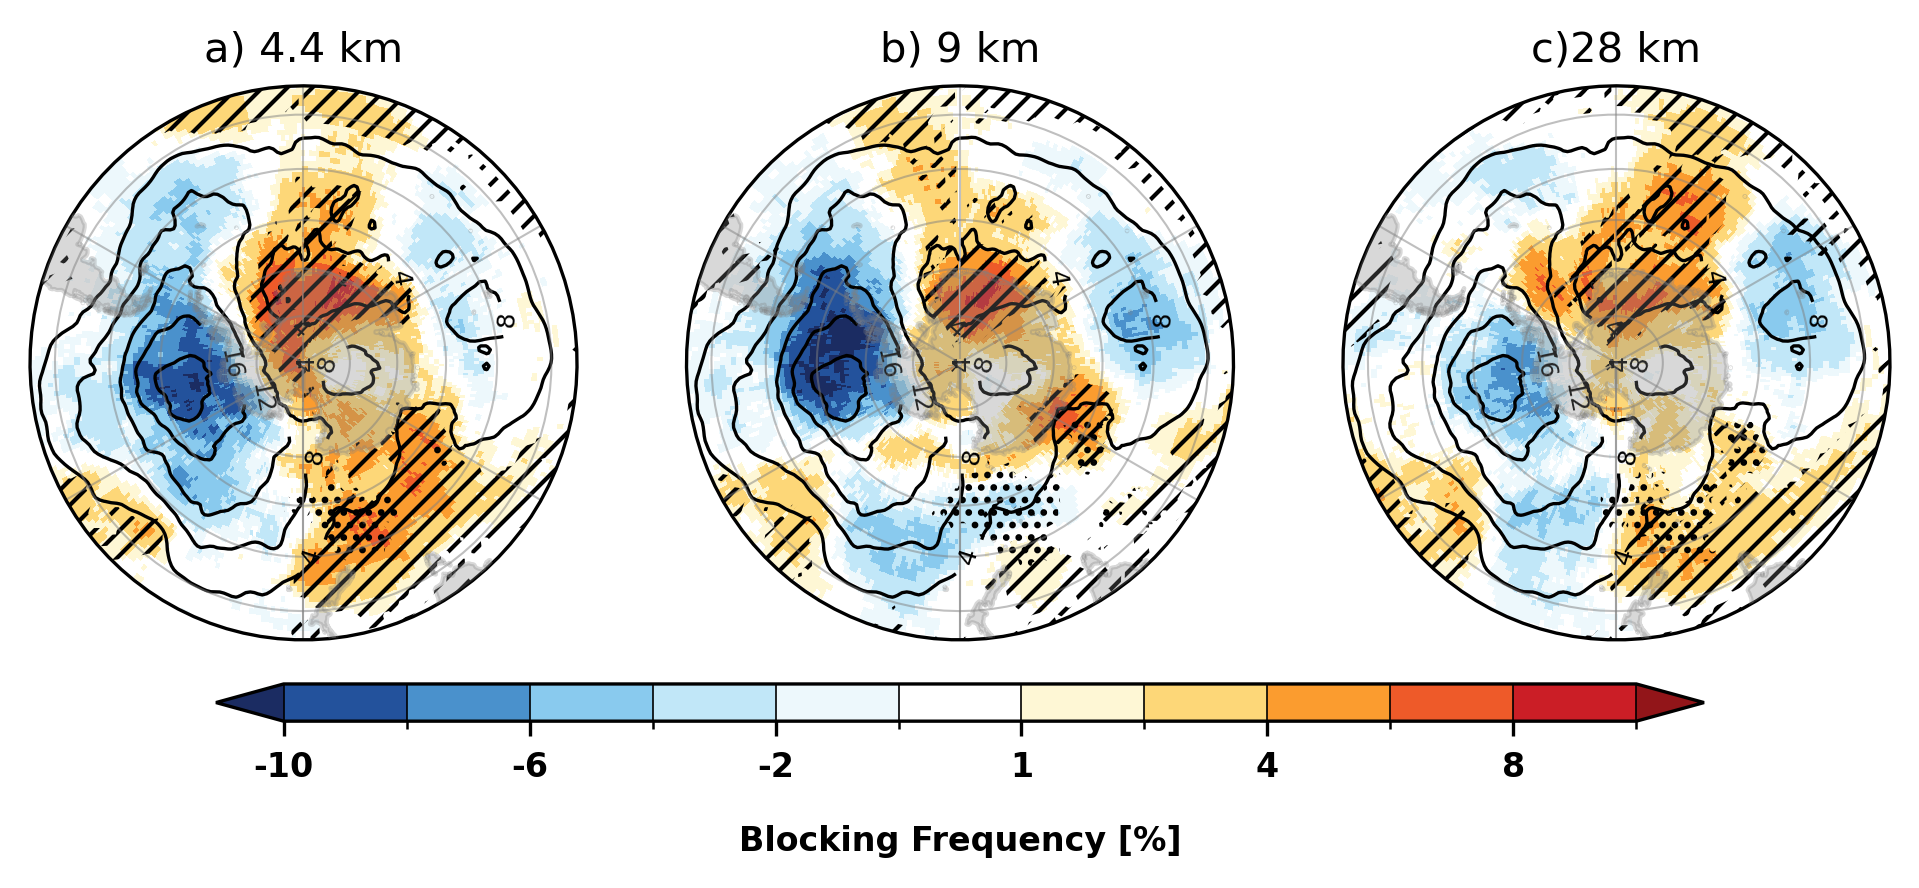

In [12]:
### Hemisphere selection
hemisphere = 'SH'  # 'NH' or 'SH'

###### Define contour levels
if hemisphere=='NH':    
    if sufix == 'DJF':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-10, -8,-6, -4, -2, -1,1, 2,  4, 6,8, 10]
    if sufix == 'JJA':
        main_levels = [2, 4, 6, 8, 10, 12, 14]
        contour_levels = [-5, -4,-3, -2, -1,  1,  2, 3,4, 5]
if hemisphere=='SH':    
    if sufix == 'JJA':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-10, -8,-6, -4, -2, -1,1, 2,  4, 6,8, 10]
    if sufix == 'DJF':
        main_levels = [2, 4, 6, 8, 10, 12, 14]
        contour_levels = [-5, -4,-3, -2, -1,  1,  2, 3,4, 5]



hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 3, figsize=(8, 6), dpi=300, subplot_kw={'projection': proj})

### Define data and titles: 
data_list = [bias_block_ens[0,...], bias_block_ens[4,...], bias_block_ens[3,...]]
data_rel = [bias_block_rel[0,...], bias_block_rel[4,...], bias_block_rel[3,...]]
data_sig = [significant_4km, significant_9km, significant_28km]
titles = ['a) 4.4 km', 'b) 9 km', 'c)28 km']

#data_list = [bias_block_ens[0,...], bias_block_ens[4,...],  bias_block_ens[3,...]]
#titles = ['a) 4.4 km', 'b) 9 km', 'c) 28 km']

cmaps = [cpt_convert, cpt_convert, cpt_convert]
extend_modes = ['both', 'both', 'both']

### Create a normalization based on contour levels for a consistent colorbar
norm = plt.Normalize(vmin=min(contour_levels), vmax=max(contour_levels))

plots = None  # To store the plot objects for colorbar
### Loop through subplots
for ax, data, rel, significant, title, cmap, extend in zip(axes.flatten(), data_list,data_rel, data_sig, titles, cmaps, extend_modes):
    # Plot without individual colorbars
    plot = data.plot(ax=ax, levels=contour_levels, cmap=cmap, extend=extend, 
                     transform=ccrs.PlateCarree(), add_colorbar=False)#, norm=norm)
    
    # Contours using ERA5 as a reference
    contour = ax.contour(clon, acc_era5.lat, acc_era5_new, colors='k', linewidths=0.8, 
                                    levels=main_levels, transform=ccrs.PlateCarree())
    ax.clabel(contour, fontsize=6, fmt='%d', inline=True, inline_spacing=-2)

    # Ensure the mask is binary (1 for True, 0 for False)
    significant_mask = significant.astype(int)

    density=4
    ax.contourf(
        significant.lon, significant.lat, significant_mask,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'.',density*'.'],
        )

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )
    
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                               edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_title(title, fontsize=10)


### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

# Save the image
plt.savefig(f'RESOLUTION_IFS_block_bias_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)


In [13]:
#relative_mask = bias_block_rel[0,...]>100
#bias_block_rel[0,...].plot()
#relative_mask.plot()
#significant_mask = compute_significant_v3(blocks_era5, block_ifs_ens[0,...])
#significant_mask.plot()
sufix

'JJA'

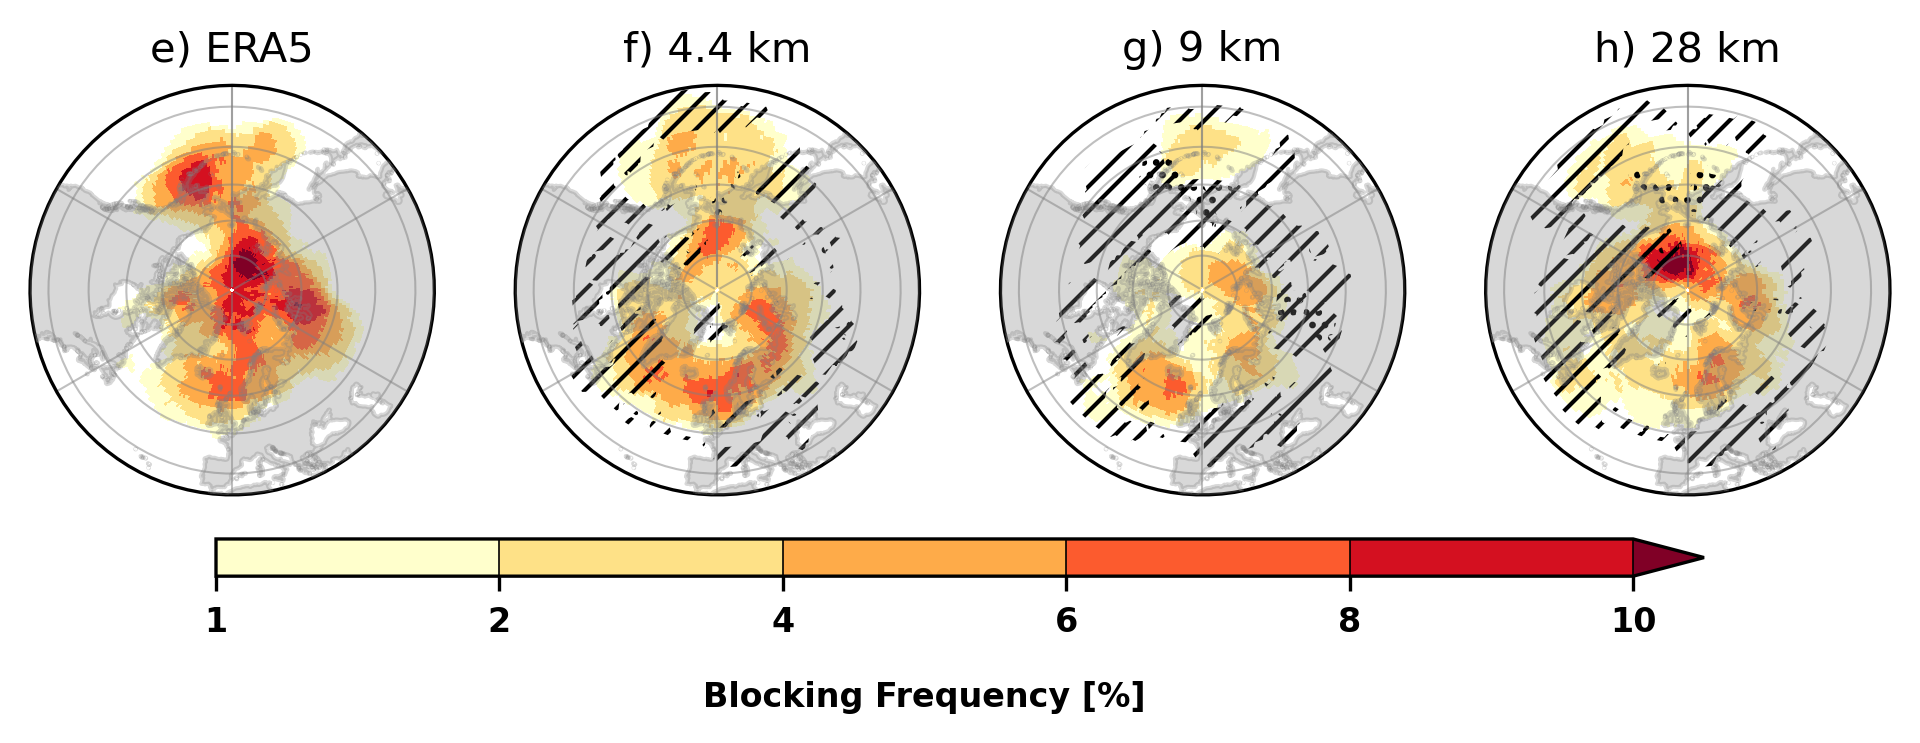

In [14]:
### Hemisphere selection
hemisphere = 'NH'  # 'NH' or 'SH'

### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12, 14]
contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

###### Define contour levels
if hemisphere=='NH': 
    if sufix == 'DJF':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-10, -8,-6, -4, -2, -1,1, 2,  4, 6,8, 10]
        titles = ['a) ERA5', 'b) 4.4 km','c) 9 km','d) 28 km']
    if sufix == 'JJA':
        main_levels = [1, 2, 4, 6, 8, 10]
        contour_levels = [-5, -4,-3, -2, -1,  1,  2, 3,4, 5]
        titles = ['e) ERA5', 'f) 4.4 km','g) 9 km','h) 28 km']
if hemisphere=='SH': 
    if sufix == 'JJA':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-10, -8,-6, -4, -2, -1,1, 2,  4, 6,8, 10]
        titles = ['e) ERA5', 'f) 4.4 km','g) 9 km','h) 28 km']
    if sufix == 'DJF':
        main_levels = [1, 2, 4, 6, 8, 10]
        contour_levels = [-5, -4,-3, -2, -1,  1,  2, 3,4, 5]
        titles = ['a) ERA5', 'b) 4.4 km','c) 9 km','d) 28 km']
        
hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 4, figsize=(8, 6), dpi=300, subplot_kw={'projection': proj})

### Define data and titles
data_list = [acc_era5, block_ifs_ens[0,...], block_ifs_ens[4,...], block_ifs_ens[3,...]]
data_rel = [(bias_block_rel[0,...]*0),bias_block_rel[0,...], bias_block_rel[4,...], bias_block_rel[3,...]]
data_sig = [significant_4km*0,significant_4km, significant_9km, significant_28km]


cmaps = ['YlOrRd', 'YlOrRd', 'YlOrRd', 'YlOrRd']
extend_modes = ['max', 'max', 'max', 'max']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

plot=None
### Loop through subplots
for ax, data, rel, significant, title, cmap, extend in zip(axes.flatten(), data_list, data_rel, data_sig, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels=main_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using ERA5 as a reference
#    contour = acc_era5.plot.contour(ax=ax, colors='k', linewidths=0.8, levels=main_levels, transform=ccrs.PlateCarree())
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )

# Ensure the mask is binary (1 for True, 0 for False)
    significant_mask = significant.astype(int)

    density=4
    ax.contourf(
        significant.lon, significant.lat, significant_mask,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'.',density*'.'],
        )
    
    
    # Set title
    ax.set_title(title, fontsize=10)

### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(main_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

# Save the image
plt.savefig(f'RESOLUTION_IFS_block_abs_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

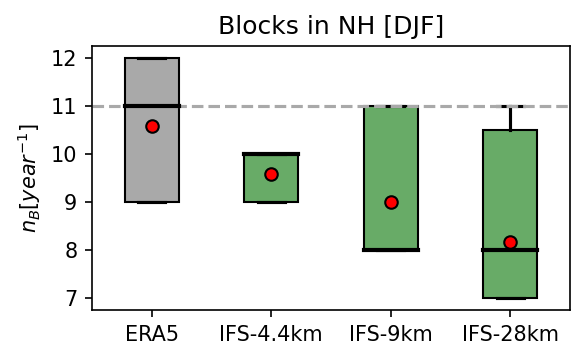

In [15]:
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='DJF' ### YEAR, DJF, JJA

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")
    
# Get CSV files list from a folder
###IFS 4km
file = '/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.csv'
ifs_df_4km = pd.read_csv(file)
ifs_df_4km['year']=ifs_df_4km.Date.str[:4]
ifs_df_4km['month']=ifs_df_4km.Date.str[4:6]

###IFS 9 km
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.csv'
ifs_df_9km = pd.read_csv(file)
ifs_df_9km['year']=ifs_df_9km.Date.str[:4]
ifs_df_9km['month']=ifs_df_9km.Date.str[4:6]
### Select 5 years only
ifs_df_9km= ifs_df_9km[ifs_df_9km['year'].isin( ['2020', '2021', '2022','2023','2024'])]


###IFS 28 km
file = '/scratch/b/b382006/nextgems/cycle3/IFS_28-FESOM_25-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.csv'
ifs_df_28km = pd.read_csv(file)
ifs_df_28km['year']=ifs_df_28km.Date.str[:4]
ifs_df_28km['month']=ifs_df_28km.Date.str[4:6]

##ERA5
file = '/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
### Select 5 years only
era5_df = era5_df[era5_df['year'].isin( ['2015', '2016', '2017','2018','2019'])]

### filter domain
if domain == 'NH':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 ) & (ifs_df_4km['Longitude'] > -90 ) & (ifs_df_4km['Longitude'] < 90 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & (ifs_df_9km['Longitude'] > -90 ) & (ifs_df_9km['Longitude'] < 90 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 ) & (ifs_df_28km['Longitude'] > -90 ) & (ifs_df_28km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 ) & ((ifs_df_4km['Longitude'] > 90 ) | (ifs_df_4km['Longitude'] < -90 ))]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & ((ifs_df_9km['Longitude'] > 90 ) | (ifs_df_9km['Longitude'] < -90 ))]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 ) & ((ifs_df_28km['Longitude'] > 90 ) | (ifs_df_28km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] < 0 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] < 0 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]

### select season
ifs_df_4km = ifs_df_4km[ifs_df_4km['month'].isin(months)]
ifs_df_9km = ifs_df_9km[ifs_df_9km['month'].isin(months)]
ifs_df_28km = ifs_df_28km[ifs_df_28km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]
    

# Color definitions
color_ifs = '#68ab67'
color_icon = '#6b64ff'
color_era5 = 'darkgrey'
color_cmip6 = '#db6f30'

# Sample DataFrame simulation
# Replace this with your actual DataFrame values
era5_values = era5_df.groupby('year')['Flag'].nunique().values
ifs_values_4km = ifs_df_4km.groupby('year')['Flag'].nunique().values
ifs_values_9km = ifs_df_9km.groupby('year')['Flag'].nunique().values
ifs_values_28km = ifs_df_28km.groupby('year')['Flag'].nunique().values

data = [era5_values, ifs_values_4km, ifs_values_9km, ifs_values_28km]
labels = ['ERA5', 'IFS-4.4km','IFS-9km', 'IFS-28km']
colors = [color_era5, color_ifs, color_ifs, color_ifs]

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True,showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Custom colors for boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Median ({mean_era5:.2f})')


ax.set_ylabel('$n_{B}$[$year^{-1}$]')
ax.set_title('Blocks in '+domain+' ['+sufix+']')

plt.tight_layout()
plt.savefig('RESOLUTION_number-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

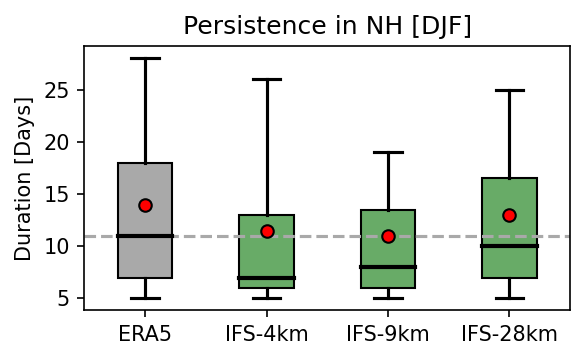

In [16]:
### persistence
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='DJF' ### YEAR, DJF, JJA

    
if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")

# Get CSV files list from a folder
###IFS
file = '/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.csv'
ifs_df_4km = pd.read_csv(file)
ifs_df_4km['year']=ifs_df_4km.Date.str[:4]
ifs_df_4km['month']=ifs_df_4km.Date.str[4:6]
ifs_values_4km = ifs_df_4km.groupby('Flag').size().reset_index(name='Duration')
ifs_df_4km = ifs_df_4km.merge(ifs_values_4km, on='Flag', how='left')

###IFS 9 km
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.csv'
ifs_df_9km = pd.read_csv(file)
ifs_df_9km['year']=ifs_df_9km.Date.str[:4]
ifs_df_9km['month']=ifs_df_9km.Date.str[4:6]
ifs_values_9km = ifs_df_9km.groupby('Flag').size().reset_index(name='Duration')
ifs_df_9km = ifs_df_9km.merge(ifs_values_9km, on='Flag', how='left')
### Select 5 years only
ifs_df_9km= ifs_df_9km[ifs_df_9km['year'].isin( ['2020', '2021', '2022','2023','2024'])]


###IFS
file = '/scratch/b/b382006/nextgems/cycle3/IFS_28-FESOM_25-cycle3/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2025.csv'
ifs_df_28km = pd.read_csv(file)
ifs_df_28km['year']=ifs_df_28km.Date.str[:4]
ifs_df_28km['month']=ifs_df_28km.Date.str[4:6]
ifs_values_28km = ifs_df_28km.groupby('Flag').size().reset_index(name='Duration')
ifs_df_28km = ifs_df_28km.merge(ifs_values_28km, on='Flag', how='left')

##ERA5
file = '/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
era5_values = era5_df.groupby('Flag').size().reset_index(name='Duration')
era5_df = era5_df.merge(era5_values, on='Flag', how='left')

### Select 5 years only
era5_df = era5_df[era5_df['year'].isin( ['2015', '2016', '2017','2018','2019'])]

### filter domain
if domain == 'NH':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 ) & (ifs_df_4km['Longitude'] > -90 ) & (ifs_df_4km['Longitude'] < 90 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & (ifs_df_9km['Longitude'] > -90 ) & (ifs_df_9km['Longitude'] < 90 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 ) & (ifs_df_28km['Longitude'] > -90 ) & (ifs_df_28km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] > 0 ) & ((ifs_df_4km['Longitude'] > 90 ) | (ifs_df_4km['Longitude'] < -90 ))]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & ((ifs_df_9km['Longitude'] > 90 ) | (ifs_df_9km['Longitude'] < -90 ))]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] > 0 ) & ((ifs_df_28km['Longitude'] > 90 ) | (ifs_df_28km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    ifs_df_4km = ifs_df_4km[(ifs_df_4km['Latitude'] < 0 )]
    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] < 0 )]
    ifs_df_28km = ifs_df_28km[(ifs_df_28km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]


ifs_df_4km = ifs_df_4km[ifs_df_4km['month'].isin(months)]
ifs_df_9km = ifs_df_9km[ifs_df_9km['month'].isin(months)]
ifs_df_28km = ifs_df_28km[ifs_df_28km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]

### keep only unique flags
ifs_values_4km = ifs_df_4km.drop_duplicates(subset=['Flag']).reset_index(drop=True)
ifs_values_9km = ifs_df_9km.drop_duplicates(subset=['Flag']).reset_index(drop=True)
ifs_values_28km = ifs_df_28km.drop_duplicates(subset=['Flag']).reset_index(drop=True)
era5_values = era5_df.drop_duplicates(subset=['Flag']).reset_index(drop=True)


data = [era5_values['Duration'].values, ifs_values_4km['Duration'].values,ifs_values_9km['Duration'].values, ifs_values_28km['Duration'].values]
labels = ['ERA5', 'IFS-4km','IFS-9km', 'IFS-28km']
colors = [color_era5, color_ifs, color_ifs, color_ifs]


# Create a plot
###
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True, showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Custom colors for boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values['Duration'].values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Mean ({mean_era5:.2f})')


ax.set_ylabel('Duration [Days]')
ax.set_title('Persistence in '+domain+' ['+sufix+']')

plt.tight_layout()

plt.savefig('RESOLUTION_duration-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

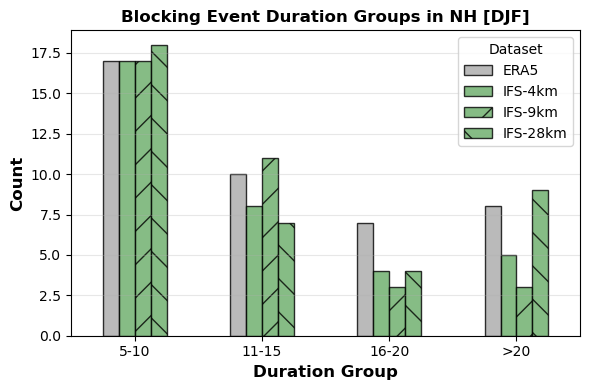

In [17]:
# Define bins and labels
bins = [5, 10, 15, 20, float('inf')]
labels = ['5-10', '11-15', '16-20', '>20']

# Apply binning to each dataset
era5_values['Duration Group'] = pd.cut(era5_values['Duration'], bins=bins, labels=labels, right=True)
ifs_values_4km['Duration Group'] = pd.cut(ifs_values_4km['Duration'], bins=bins, labels=labels, right=True)
ifs_values_9km['Duration Group'] = pd.cut(ifs_values_9km['Duration'], bins=bins, labels=labels, right=True)
ifs_values_28km['Duration Group'] = pd.cut(ifs_values_28km['Duration'], bins=bins, labels=labels, right=True)

# Count occurrences in each group
era5_counts = era5_values['Duration Group'].value_counts().sort_index()
ifs_9km_counts = ifs_values_9km['Duration Group'].value_counts().sort_index()
ifs_4km_counts = ifs_values_4km['Duration Group'].value_counts().sort_index()
ifs_28km_counts = ifs_values_28km['Duration Group'].value_counts().sort_index()

# Create a DataFrame to compare counts
duration_df = pd.DataFrame({'ERA5': era5_counts, 'IFS-4km': ifs_4km_counts,'IFS-9km': ifs_9km_counts, 'IFS-28km': ifs_28km_counts}).fillna(0)

# Define hatching patterns (consistent for each dataset)
hatch_patterns = {'ERA5': None, 'IFS-4km': None,'IFS-9km': '/', 'IFS-28km': '\\'}

# Plot grouped bar chart
ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_ifs, color_ifs,color_ifs], alpha=0.8, edgecolor='black')

# Apply hatching consistently per dataset
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])  # Apply consistent hatching

plt.title('Blocking Event Duration Groups in ' + domain + ' [' + sufix + ']', fontsize=12, weight="bold")
plt.xlabel('Duration Group', fontsize=12, weight="bold")
plt.ylabel('Count', fontsize=12, weight="bold")
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()

#plt.savefig('RESOLUTION_duration-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

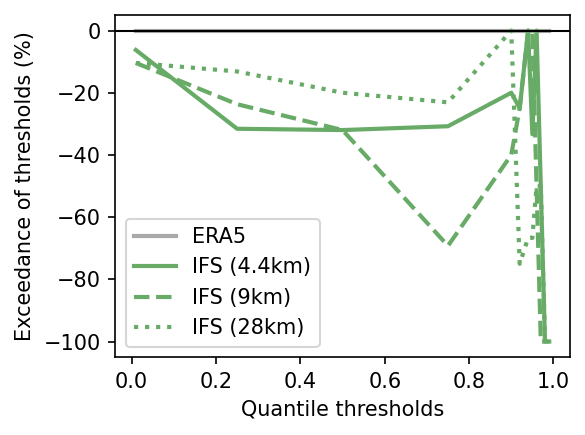

In [18]:
### Comparing different percentiles 
def idxquantile(s,q=0.01, *args, **kwargs):
    qv=s.quantile(q, *args, **kwargs)
    return (s.sort_values(by='ERA5')[::-1] <= qv).idxmax()

inty_dfs = pd.DataFrame({
    'ERA5':era5_values['Duration'],
    'IFS (4.4km)':ifs_values_4km['Duration'],
    'IFS (9km)':ifs_values_9km['Duration'],
    'IFS (28km)':ifs_values_28km['Duration'],
       })

qts=[0.01,0.25, 0.5, 0.75, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
era5_qts=pd.DataFrame(inty_dfs['ERA5'].quantile(qts))

j=0
accumulator=[]

for i in qts:
    ctrl=inty_dfs['ERA5'].ge(era5_qts['ERA5'].iloc[j]).sum() 
    test=inty_dfs.ge(era5_qts['ERA5'].iloc[j]).sum()     
    tmp_df = pd.DataFrame(((test - ctrl) / ctrl) * 100).T  # Compute exceedance percentage
    accumulator.append(tmp_df)
    j=j+1

percentile_df = pd.concat(accumulator).reset_index(drop=True)

fig,ax = plt.subplots(figsize=(4,3),dpi=150,tight_layout=True)

plt.plot(qts, percentile_df['ERA5'], color=color_era5,linewidth=2, label='ERA5')
plt.plot(qts, percentile_df['IFS (4.4km)'],color=color_ifs,linestyle="solid",linewidth=2,label='IFS (4.4km)')
plt.plot(qts, percentile_df['IFS (9km)'],color=color_ifs,linestyle="--",linewidth=2,label='IFS (9km)')
plt.plot(qts, percentile_df['IFS (28km)'],color=color_ifs,linestyle=":",linewidth=2,label='IFS (28km)')

plt.tick_params(labelsize=10)

ax.set_xlabel('Quantile thresholds', fontsize=10)
ax.set_ylabel('Exceedance of thresholds (%)', fontsize=10)

ax.axhline(0, color='k', lw=1)

plt.legend()

# Cycle 4 (prefinal)

## Plotting frequency ANOM metric

In [19]:
###### Compute mean frequency
sufix='JJA' ### YEAR, DJF, JJA
## Hemisphere
hemisphere='NH' ### NH, SH

In [20]:
### ERA5
era5_z500_day=xr.open_dataset("/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.nc")
era5_z500_day=era5_z500_day.rename({'latitude':'lat'})
era5_z500_day=era5_z500_day.rename({'longitude':'lon'})
era5_z500_day=era5_z500_day.sortby('lat', ascending=True)

ifs_z500_day=xr.open_dataset("/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_Z500_90th/BLOCKS-ifs-production-1990-2019.nc")
era5_z500_day

###=== ERA5 
if sufix =='YEAR':
    blocks_era5=era5_z500_day
if sufix =='DJF':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([6, 7, 8]))
    
### accumulate 
acc_era5 = xr.where(blocks_era5['flag']>1,1,0).mean(dim='time')*100


###=== IFS hirtorical
if sufix =='YEAR':
    blocks_ifs_his=ifs_z500_day
if sufix =='DJF':
    blocks_ifs_his=ifs_z500_day.sel(time=ifs_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_his=ifs_z500_day.sel(time=ifs_z500_day.time.dt.month.isin([6, 7, 8]))

### sampling
#y0='1990' ## 2015, 2020, 2020, 2044
#yn='2010' ## 2019, 2049, 2025, 2049
#blocks_ifs_his=blocks_ifs_his.sel(time=slice(y0,yn))

### accumulate 
acc_ifs_his = xr.where(blocks_ifs_his['flag']>1,1,0).mean(dim='time')*100

In [21]:
### Test adding size information to filter out small blocks
'''
import pandas as pd
import xarray as xr
import numpy as np
# Get CSV files list from a folder
###IFS
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_Z500_90th/BLOCKS-ifs-production-1990-2019.csv'
ifs_df = pd.read_csv(file)

###ERA5
file = '/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)

### Take size (maybe only > 2×10^6 km2 )
#era5_filtered = era5_df[era5_df['Size'] > 2000000].reset_index(drop=True)
#ifs_filtered = ifs_df[ifs_df['Size'] > 2000000].reset_index(drop=True)
#era5_df #filtered
#xr.where(blocks_era5['flag']>1,1,0)

# Example DataArray
da =  era5_z500_day['flag']
# Ensure the Date format matches the DataArray's time coordinate
era5_df["Date"] = pd.to_datetime(era5_df["Date"].str[:8], format="%Y%m%d")

# Create an empty DataArray for Size
size_da = xr.DataArray(
    np.full_like(da, fill_value=np.nan, dtype=float),
    dims=da.dims,
    coords=da.coords,
    name="Size",
)

# Update Size DataArray where conditions are met
for _, row in era5_df.iterrows():
    time_idx = np.where(da.time.values == row["Date"])[0]
    lat_idx = np.where(da.latitude.values == row["Latitude"])[0]
    lon_idx = np.where(da.longitude.values == (row["Longitude"] % 360))[0]
    
    if time_idx.size > 0 and lat_idx.size > 0 and lon_idx.size > 0:
        size_da.values[time_idx[0], lat_idx[0], lon_idx[0]] = row["Size"]

# Combine flag and size into a new dataset (optional)
result_ds = xr.Dataset({"flag": da, "Size": size_da})
result_ds
'''

'\nimport pandas as pd\nimport xarray as xr\nimport numpy as np\n# Get CSV files list from a folder\n###IFS\nfile = \'/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_Z500_90th/BLOCKS-ifs-production-1990-2019.csv\'\nifs_df = pd.read_csv(file)\n\n###ERA5\nfile = \'/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv\'\nera5_df = pd.read_csv(file)\n\n### Take size (maybe only > 2×10^6\u2009km2 )\n#era5_filtered = era5_df[era5_df[\'Size\'] > 2000000].reset_index(drop=True)\n#ifs_filtered = ifs_df[ifs_df[\'Size\'] > 2000000].reset_index(drop=True)\n#era5_df #filtered\n#xr.where(blocks_era5[\'flag\']>1,1,0)\n\n# Example DataArray\nda =  era5_z500_day[\'flag\']\n# Ensure the Date format matches the DataArray\'s time coordinate\nera5_df["Date"] = pd.to_datetime(era5_df["Date"].str[:8], format="%Y%m%d")\n\n# Create an empty DataArray for Size\nsize_da = xr.DataArray(\n    np.full_like(da, fill_value=np.nan, dtype=float),\n    dims=da.dims,\n    

In [22]:
###=== Save CMIP6 freqeuncies 
'''
# 'ACCESS-CM2', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MIROC6','MRI-ESM2-0'
model='MIROC6'
ens='r1i1p1f1' #'r1i1p1f1', 'r11i1p1f1'
inpath='/scratch/b/b382006/cmip6/historical/'+model+'/'+ens+'/block/ANO_Z500_90th/'
sufix='JJA' ### YEAR, DJF, JJA

### open file
cmip6_z500_day=xr.open_dataset(inpath+"BLOCKS-cmip6-1985-2014.nc")

### select period
if sufix =='YEAR':
    blocks_cmip6_tmp = cmip6_z500_day 
if sufix =='DJF':
    blocks_cmip6_tmp = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_cmip6_tmp = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([6, 7, 8]))

### accumulate 
acc_cmip6 = xr.where(blocks_cmip6_tmp['flag']>1,1,0).mean(dim='time')*100

###Save season as netcdf CMIP6
if sufix =='YEAR':
    acc_cmip6.to_netcdf(inpath+'Feq_BLOCKS-cmip6_'+sufix+'.nc')
if sufix =='DJF':
    acc_cmip6.to_netcdf(inpath+'Feq_BLOCKS-cmip6_'+sufix+'.nc')
if sufix =='JJA':
    acc_cmip6.to_netcdf(inpath+'Feq_BLOCKS-cmip6_'+sufix+'.nc')

print('done')
'''

'\n# \'ACCESS-CM2\', \'CESM2\', \'CESM2-WACCM\', \'EC-Earth3\', \'MPI-ESM1-2-HR\', \'MPI-ESM1-2-LR\', \'MIROC6\',\'MRI-ESM2-0\'\nmodel=\'MIROC6\'\nens=\'r1i1p1f1\' #\'r1i1p1f1\', \'r11i1p1f1\'\ninpath=\'/scratch/b/b382006/cmip6/historical/\'+model+\'/\'+ens+\'/block/ANO_Z500_90th/\'\nsufix=\'JJA\' ### YEAR, DJF, JJA\n\n### open file\ncmip6_z500_day=xr.open_dataset(inpath+"BLOCKS-cmip6-1985-2014.nc")\n\n### select period\nif sufix ==\'YEAR\':\n    blocks_cmip6_tmp = cmip6_z500_day \nif sufix ==\'DJF\':\n    blocks_cmip6_tmp = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([1, 2, 12]))\nif sufix ==\'JJA\':\n    blocks_cmip6_tmp = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([6, 7, 8]))\n\n### accumulate \nacc_cmip6 = xr.where(blocks_cmip6_tmp[\'flag\']>1,1,0).mean(dim=\'time\')*100\n\n###Save season as netcdf CMIP6\nif sufix ==\'YEAR\':\n    acc_cmip6.to_netcdf(inpath+\'Feq_BLOCKS-cmip6_\'+sufix+\'.nc\')\nif sufix ==\'DJF\':\n    acc_cmip6.to_netcdf(inpath+\'Feq_B

In [23]:
### Open cmip6 models '/scratch/b/b382006/cmip6/'+model+'/'+ens+'/block/ANO_Z500/'
### dictonary with models
models=[
    'MRI-ESM2-0',
    'ACCESS-CM2',
    'EC-Earth3',    
    'MPI-ESM1-2-HR',
    'CESM2-WACCM', 
    'MIROC6',
    'MPI-ESM1-2-LR',
    'CESM2'
    ]

var='flag'
query = dict(
    source_id=models,  #Only choosing one model here
    member_id=['r10i1p1f1', 
               'r1i1p1f1', 
               'r2i1p1f1', 
               'r3i1p1f1', 
               'r4i1p1f1', 
               'r5i1p1f1', 
               'r6i1p1f1', 
               'r7i1p1f1', 
               'r8i1p1f1', 
               'r9i1p1f1',
               'r11i1p1f1']
    )
block_cmip6=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    if sid=='CESM2':
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/historical/'+sid+'/'+query['member_id'][10]+'/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()
    else:
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/historical/'+sid+'/'+query['member_id'][1]+'/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()

    block_cmip6.append(tmp[var] )
    print(sid,'/scratch/b/b382006/cmip6/'+sid+'/'+query['member_id'][1]+'/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_'+sufix+'.nc')

#concatening
block_cmip6_ens=xr.concat(block_cmip6, "model")
#block_cmip6

MRI-ESM2-0 /scratch/b/b382006/cmip6/MRI-ESM2-0/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
ACCESS-CM2 /scratch/b/b382006/cmip6/ACCESS-CM2/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
EC-Earth3 /scratch/b/b382006/cmip6/EC-Earth3/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
MPI-ESM1-2-HR /scratch/b/b382006/cmip6/MPI-ESM1-2-HR/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
CESM2-WACCM /scratch/b/b382006/cmip6/CESM2-WACCM/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
MIROC6 /scratch/b/b382006/cmip6/MIROC6/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
MPI-ESM1-2-LR /scratch/b/b382006/cmip6/MPI-ESM1-2-LR/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc
CESM2 /scratch/b/b382006/cmip6/CESM2/r1i1p1f1/block/ANO_Z500_90th/Feq_BLOCKS-cmip6_JJA.nc


In [24]:
####### filters for stetics
acc_era5_fil = gaussian_filter(acc_era5, sigma=1)
acc_era5_new, clon = cutil.add_cyclic(acc_era5_fil, acc_era5.lon)


#### compute BIAS
## ifs bias
ifs_his_bias =  acc_ifs_his -acc_era5
ifs_his_bias_rel=  (acc_ifs_his -acc_era5) / acc_era5*1e2

### cmip6 bias
### for ensemble mean
block_cmip6=block_cmip6_ens.mean(axis=0)
### bias_cmip6=  block_cmip6 - acc_era5
### from each model
bias_block_ens = block_cmip6_ens - acc_era5
bias_block_ens_rel = (block_cmip6_ens - acc_era5) /  acc_era5*1e2

bias_cmip6 = bias_block_ens.mean(axis=0)
bias_cmip6_rel= bias_block_ens_rel.mean(axis=0) #(block_cmip6 - acc_era5)/ acc_era5*1e2

### Model difference IFS - CMIP6
ifs_diff=  acc_ifs_his - block_cmip6
ifs_diff_rel=  (acc_ifs_his - block_cmip6) / block_cmip6*1e2

### significance #########
### signicance CMIP6
sig_cmip6 = calc_agree(block_cmip6_ens,acc_era5)

### signicance IFS
pval_da, mask_ifs, freq_diff_da= compare_blocking_frequency(xr.where(blocks_ifs_his['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)

adj_pvals, sig_ifs_his = apply_fdr(pval_da)

#print(sig_ifs.shape, blocks_ifs_his.flag.shape, blocks_era5.flag.shape)

Calculated disagree


In [25]:
#sig_cmip6

In [26]:
### IFS historical
''''
### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12, 14]
contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

if sufix == 'DJF':
    main_levels = [4, 8, 12, 16, 20]
    contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]
if sufix == 'JJA':
    main_levels = [2, 4, 6, 8, 10, 12, 14]
    contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
    

### Hemisphere selection
#hemisphere = 'SH'  # 'NH' or 'SH'

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=300, subplot_kw={'projection': proj})

### Define data and titles
data_list = [ifs_his_bias, bias_cmip6, ifs_diff]
data_rel = [ifs_his_bias_rel, bias_cmip6_rel, ifs_diff_rel]
data_sig = [sig_ifs_his, sig_cmip6, sig_ifs_his*0]

titles = ['a) IFS hist', 'b) CMIP6(x8)', 'c) IFS hist - CMIP6']
cmaps = [cpt_convert, cpt_convert,cpt_convert]
extend_modes = ['both', 'both', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

### Initialize plot variable for colorbar
plot = None
### Loop through subplots
for ax, data, rel,significant, title, cmap, extend in zip(axes.flatten(), data_list, data_rel, data_sig, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels= contour_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using ERA5 as a reference
    # Contours using ERA5 as a reference
    contour = ax.contour(clon, acc_era5.lat, acc_era5_new, colors='k', linewidths=0.8, 
                                    levels=main_levels, transform=ccrs.PlateCarree())
    ax.clabel(contour, fontsize=6, fmt='%d', inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )

# Ensure the mask is binary (1 for True, 0 for False)
    significant_mask = significant.astype(int)

    density=4
    ax.contourf(
        significant_mask.lon, significant_mask.lat, significant_mask,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'.',density*'.'],
        )
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)


### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

### Save figure
plt.savefig(f'IFS_block_bias_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)
'''

'\'\n### Define contour levels\nmain_levels = [2, 4, 6, 8, 10, 12, 14]\ncontour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]\n\nif sufix == \'DJF\':\n    main_levels = [4, 8, 12, 16, 20]\n    contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]\nif sufix == \'JJA\':\n    main_levels = [2, 4, 6, 8, 10, 12, 14]\n    contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]\n    \n\n### Hemisphere selection\n#hemisphere = \'SH\'  # \'NH\' or \'SH\'\n\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.v

In [27]:
## each cmip6 separately
'''
### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12, 14]
contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

if sufix == 'DJF':
    main_levels = [4, 8, 12, 16, 20]
    contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]
if sufix == 'JJA':
    main_levels = [2, 4, 6, 8, 10, 12, 14]
    contour_levels = [-3, -2.5, -2, -1.5, -1, -0.5, -0.1,0.1,0.5, 1, 1.5, 2, 2.5, 3]
    

### Hemisphere selection
#hemisphere = 'SH'  # 'NH' or 'SH'

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(3, 3, figsize=(8, 8), dpi=100, subplot_kw={'projection': proj})

### Define data and titles
### bias_block_ens
data_list = [bias_block_ens[0,...], bias_block_ens[1,...],bias_block_ens[2,...], 
             bias_block_ens[3,...], bias_block_ens[4,...],bias_block_ens[5,...],
             bias_block_ens[6,...], bias_block_ens[7,...]]
data_rel = [bias_block_ens_rel[0,...], bias_block_ens_rel[1,...], bias_block_ens_rel[2,...],
            bias_block_ens_rel[3,...], bias_block_ens_rel[4,...], bias_block_ens_rel[5,...],
            bias_block_ens_rel[6,...], bias_block_ens_rel[7,...]]

titles=models
cmaps = [cpt_convert, cpt_convert,cpt_convert,cpt_convert, cpt_convert,cpt_convert, cpt_convert,cpt_convert]
extend_modes = ['both', 'both', 'both','both', 'both', 'both', 'both', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

### Initialize plot variable for colorbar
plot = None
### Loop through subplots
for ax, data, rel, title, cmap, extend in zip(axes.flatten(), data_list, data_rel, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels= contour_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using ERA5 as a reference
    # Contours using ERA5 as a reference
    contour = ax.contour(clon, acc_era5.lat, acc_era5_new, colors='k', linewidths=0.8, 
                                    levels=main_levels, transform=ccrs.PlateCarree())
    ax.clabel(contour, fontsize=6, fmt='%d', inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)


### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)
'''

'\n### Define contour levels\nmain_levels = [2, 4, 6, 8, 10, 12, 14]\ncontour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]\n\nif sufix == \'DJF\':\n    main_levels = [4, 8, 12, 16, 20]\n    contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]\nif sufix == \'JJA\':\n    main_levels = [2, 4, 6, 8, 10, 12, 14]\n    contour_levels = [-3, -2.5, -2, -1.5, -1, -0.5, -0.1,0.1,0.5, 1, 1.5, 2, 2.5, 3]\n    \n\n### Hemisphere selection\n#hemisphere = \'SH\'  # \'NH\' or \'SH\'\n\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstac

In [28]:
###
#icon_interp = icon_his_bias.interp(lon=ifs_his_bias.lon) # Interpolate ICON to IFS grid
#kms_bias = (ifs_his_bias + icon_interp)/2

### Climate chnange (long simulations)

In [29]:
anom_version='ANO_Z500_90th' #ANO_Z500_90th, ANO_Z5002

### open IFS fut file
ifs_z500_day_fut=xr.open_dataset("/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/"+anom_version+"/BLOCKS-ifs-production-2020-2049.nc")

#### IFS
if sufix =='YEAR':
    blocks_ifs_fut=ifs_z500_day_fut
if sufix =='DJF':
    blocks_ifs_fut=ifs_z500_day_fut.sel(time=ifs_z500_day_fut.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_fut=ifs_z500_day_fut.sel(time=ifs_z500_day_fut.time.dt.month.isin([6, 7, 8])) 
    
acc_ifs_fut = xr.where(blocks_ifs_fut['flag']>1,1,0).mean(dim='time')*100 ### accumulate IFS

### open IFS EERIE AMIP file
ifs_z500_day_amip=xr.open_dataset("/scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/"+anom_version+"/BLOCKS-ifs-production-1990-2019.nc")

#### IFS
if sufix =='YEAR':
    blocks_ifs_amip=ifs_z500_day_amip
if sufix =='DJF':
    blocks_ifs_amip=ifs_z500_day_amip.sel(time=ifs_z500_day_amip.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_amip=ifs_z500_day_amip.sel(time=ifs_z500_day_amip.time.dt.month.isin([6, 7, 8]))

acc_ifs_amip = xr.where(blocks_ifs_amip['flag']>1,1,0).mean(dim='time')*100 ### accumulate IFS 

### open IFS EERIE hist file
ifs_z500_day_hist2=xr.open_dataset("/scratch/b/b382006/EERIE/cycle1/ifs-fesom2-sr/block/"+anom_version+"/BLOCKS-ifs-production-1970-2014.nc")

#### IFS
if sufix =='YEAR':
    blocks_ifs_hist2=ifs_z500_day_hist2
if sufix =='DJF':
    blocks_ifs_hist2=ifs_z500_day_hist2.sel(time=ifs_z500_day_hist2.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_hist2=ifs_z500_day_hist2.sel(time=ifs_z500_day_hist2.time.dt.month.isin([6, 7, 8]))

acc_ifs_hist2 = xr.where(blocks_ifs_hist2['flag']>1,1,0).mean(dim='time')*100 ### accumulate IFS 

###ICON production
icon_z500_day_fut=xr.open_dataset("/scratch/b/b382006/nextgems/prefinal/ngc4008/block/"+anom_version+"/BLOCKS-icon-ngc4008-2025-2049.nc")
### change longitude to -179 to 180
icon_z500_day_fut = icon_z500_day_fut.assign_coords(lon=((icon_z500_day_fut.lon + 180) % 360 - 180)).sortby("lon")

icon_z500_day_fut=icon_z500_day_fut.sortby('lat', ascending=True)

### Remove first 5 years for cool drifting 
icon_z500_day_fut=icon_z500_day_fut.sel(time=slice('2025','2049'))

#### Season
if sufix =='YEAR':
    blocks_icon_fut=icon_z500_day_fut
if sufix =='DJF':
    blocks_icon_fut=icon_z500_day_fut.sel(time=icon_z500_day_fut.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_icon_fut=icon_z500_day_fut.sel(time=icon_z500_day_fut.time.dt.month.isin([6, 7, 8]))

acc_icon_fut = xr.where(blocks_icon_fut['flag']>1,1,0).mean(dim='time')*100 ### accumulate ICON

###ICON production DestinE
icon_z500_day_his=xr.open_dataset("/scratch/b/b382006/icon-climate-dt/block/"+anom_version+"/BLOCKS-icon-ngc4008-1993-2019.nc")
### change longitude to -179 to 180
icon_z500_day_his = icon_z500_day_his.assign_coords(lon=((icon_z500_day_his.lon + 180) % 360 - 180)).sortby("lon")
icon_z500_day_his=icon_z500_day_his.sortby('lat', ascending=True) # ascending

#### ICON
if sufix =='YEAR':
    blocks_icon_his=icon_z500_day_his
if sufix =='DJF':
    blocks_icon_his=icon_z500_day_his.sel(time=icon_z500_day_his.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_icon_his=icon_z500_day_his.sel(time=icon_z500_day_his.time.dt.month.isin([6, 7, 8]))

acc_icon_his = xr.where(blocks_icon_his['flag']>1,1,0).mean(dim='time')*100 ### accumulate ICON


############## difference absolute
ifs_chgs=  acc_ifs_fut - acc_ifs_his

### nextGEMS biases
icon_fut_bias=  acc_icon_fut - acc_era5
ifs_fut_bias=  acc_ifs_fut - acc_era5
### eerie biases
ifs_amip_bias = acc_ifs_amip - acc_era5
ifs_hist2_bias = acc_ifs_hist2  - acc_era5
### DestinE
icon_his_bias = acc_icon_his - acc_era5
icon_chgs=  acc_icon_fut - acc_icon_his
### km-scale ensemble mean biases
icon_interp = icon_his_bias.interp(lon=ifs_his_bias.lon) # Interpolate ICON to IFS grid
kms_bias = (ifs_his_bias + icon_interp)/2


############# difference RELATIVE
ifs_chgs_rel=  (acc_ifs_fut - acc_ifs_his)/acc_ifs_his*1e2
### nextGEMS biases
icon_fut_bias_rel =  (acc_icon_fut - acc_era5)/acc_era5*1e2
ifs_fut_bias_rel=  (acc_ifs_fut - acc_era5)/acc_era5*1e2
### eerie biases
ifs_amip_bias_rel = (acc_ifs_amip - acc_era5)/acc_era5*1e2
ifs_hist2_bias_rel = (acc_ifs_hist2 - acc_era5)/acc_era5*1e2
### DestinE
icon_his_bias_rel = (acc_icon_his - acc_era5)/acc_era5*1e2
icon_chgs_rel=  (acc_icon_fut - acc_icon_his)/acc_icon_his*1e2
###
icon_interp = icon_his_bias_rel.interp(lon=ifs_his_bias_rel.lon) # Interpolate ICON to IFS grid
kms_bias_rel = (ifs_his_bias_rel + icon_interp)/2

############# Signicance test
### signicance nextgems
pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_icon_fut['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_icon_fut = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_ifs_fut['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_ifs_fut = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_ifs_fut['flag']>1,1,0), xr.where(blocks_ifs_his['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_ifs_chgs = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency(xr.where(blocks_ifs_amip['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_ifs_amip = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_ifs_hist2['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_ifs_hist2 = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_icon_his['flag']>1,1,0), xr.where(blocks_era5['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_icon_his = apply_fdr(pval_da)

pval_da, mask, freq_da= compare_blocking_frequency_unequal(xr.where(blocks_icon_fut['flag']>1,1,0), xr.where(blocks_icon_his['flag']>1,1,0), alpha=0.05)
adj_pvals, sig_icon_chgs = apply_fdr(pval_da)

### storm resolving significance
bias_sr_ens=xr.concat([icon_interp,ifs_his_bias], "model")
signs = np.sign(bias_sr_ens)
agreement = (signs[0] * signs[1]) > 0
sig_sr_chgs = agreement.astype(int)

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:651: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:654: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [30]:
def ensure_latitude_ascending(ds):
    """Sort latitude in ascending order."""
    if (ds.lat[0] > ds.lat[-1]):
        return ds.sortby('lat')
    else:
        return ds

def cosine_lat_weights(ds):
    """Return cosine of latitude as weighting factor."""
    lat_rad = np.deg2rad(ds.lat)
    weights = np.cos(lat_rad)
    return xr.DataArray(weights, coords={'lat': ds.lat}, dims='lat')

def rmse(predictions, targets, lat_weights=None):
    """Compute weighted Root Mean Square Error (ignoring NaNs)."""
    diff_sq = (predictions - targets) ** 2
    if lat_weights is not None:
        # Broadcast weights to match the data shape
        weights = lat_weights.broadcast_like(diff_sq)
        diff_sq = diff_sq * weights
        return np.sqrt(np.nansum(diff_sq) / np.nansum(weights.where(~np.isnan(diff_sq))))
    else:
        return np.sqrt(np.nanmean(diff_sq))


#### Calculate RMSE by basin
def rmse_basin(predictions, targets, basin):
    """Compute RMSE over a specified basin (Atlantic or Pacific)."""
    if basin.lower() == 'atlantic':
        pred_basin = predictions.sel(lat=slice(0, 90), lon=slice(-85, 85))
        targ_basin = targets.sel(lat=slice(0, 90), lon=slice(-85, 85))
    elif basin.lower() == 'pacific':
        pred_pac1 = predictions.sel(lat=slice(0, 90), lon=slice(95, 180))
        pred_pac2 = predictions.sel(lat=slice(0, 90), lon=slice(-180, -95))
        pred_basin = xr.concat([pred_pac1, pred_pac2], dim='lon')
        
        targ_pac1 = targets.sel(lat=slice(0, 90), lon=slice(95, 180))
        targ_pac2 = targets.sel(lat=slice(0, 90), lon=slice(-180, -95))
        targ_basin = xr.concat([targ_pac1, targ_pac2], dim='lon')
    else:
        raise ValueError("Basin must be 'atlantic' or 'pacific'.")
    
#    return rmse(pred_basin, targ_basin)

    weights = cosine_lat_weights(pred_basin)
    return rmse(pred_basin, targ_basin, lat_weights=weights)

# For ICON
rmse_icon_atlantic = rmse_basin(acc_icon_his, acc_era5, basin='atlantic')
rmse_icon_pacific = rmse_basin(acc_icon_his, acc_era5, basin='pacific')

# For IFS
rmse_ifs_atlantic = rmse_basin(acc_ifs_his, acc_era5, basin='atlantic')
rmse_ifs_pacific = rmse_basin(acc_ifs_his, acc_era5, basin='pacific')

# For IFS amip
rmse_ifs_amip_atlantic = rmse_basin(acc_ifs_amip, acc_era5, basin='atlantic')
rmse_ifs_amip_pacific = rmse_basin(acc_ifs_amip, acc_era5, basin='pacific')

# For IFS + ICON hist
#icon_interp = rmse_icon_atlantic.interp(lon=rmse_ifs_atlantic.lon) # Interpolate ICON to IFS grid
rmse_kms_atlantic = (rmse_ifs_atlantic + rmse_icon_atlantic)/2
#icon_interp = rmse_icon_pacific.interp(lon=rmse_ifs_pacific.lon) # Interpolate ICON to IFS grid
rmse_kms_pacific = (rmse_ifs_pacific + rmse_icon_pacific)/2

# For CMIP6
rmse_cmip6_atlantic_values = [
    rmse_basin(block_cmip6_ens[i, ...], acc_era5, basin='atlantic')
    for i in range(8)
]
rmse_cmip6_atlantic = np.mean(rmse_cmip6_atlantic_values)

rmse_cmip6_pacific_values = [
    rmse_basin(block_cmip6_ens[i, ...], acc_era5, basin='pacific')
    for i in range(8)
]
rmse_cmip6_pacific = np.mean(rmse_cmip6_pacific_values)

print('ICON: ',rmse_icon_atlantic, 'IFS: ',rmse_ifs_atlantic,'IFS AMIP: ',rmse_ifs_amip_atlantic, 'CMIP6: ',rmse_cmip6_atlantic)
print('ICON: ',rmse_icon_pacific,'IFS: ',rmse_ifs_pacific,'IFS AMIP: ',rmse_ifs_amip_pacific,'CMIP6: ', rmse_cmip6_pacific)
print('KMS :',rmse_kms_atlantic)
print('KMS :',rmse_kms_pacific)

ICON:  0.3301165966495516 IFS:  0.620391975628784 IFS AMIP:  0.41877819541278055 CMIP6:  0.5990865261896765
ICON:  0.5108570920897681 IFS:  0.5839212677213198 IFS AMIP:  0.5833815133024092 CMIP6:  0.6810228837716608
KMS : 0.4752542861391678
KMS : 0.5473891799055439


In [31]:
#rmse_kms_atlantic.values, rmse_kms_pacific.values

In [32]:
### Climate change
'''
### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12, 14]
contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

### Hemisphere selection
#hemisphere = 'SH'  # 'NH' or 'SH'

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=150, subplot_kw={'projection': proj})

### Define data and titles
data_list = [acc_ifs_his,acc_ifs_fut, ifs_chgs]
titles = ['a) Historical','b) SSP3-7', 'c) Changes']
cmaps = ['Oranges','Oranges', cpt_convert]
extend_modes = ['max','max', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

### Loop through subplots
for ax, data, title, cmap, extend in zip(axes.flatten(), data_list, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels=contour_levels if title == 'c) Changes' else main_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=True, cbar_kwargs=cbar_kwargs)
    
    # Contours using IFS historical as a reference
    contour = acc_ifs_his.plot.contour(ax=ax, colors='k', linewidths=0.8, levels=main_levels, transform=ccrs.PlateCarree())
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)

### Save figure
#plt.savefig('IFS_block_chgs_'+sufix+'_'+hemisphere+'.jpg',bbox_inches='tight')
'''

"\n### Define contour levels\nmain_levels = [2, 4, 6, 8, 10, 12, 14]\ncontour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]\n\n### Hemisphere selection\n#hemisphere = 'SH'  # 'NH' or 'SH'\n\nhemisphere_settings = {\n    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},\n    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}\n}\n\nproj = hemisphere_settings[hemisphere]['projection']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstack([np.sin(theta), np.cos(theta)]).T\ncircle = mpath.Path(verts * radius + center)\n\n### Define figure and axes\nfig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=150, subplot_kw={'projection': proj})\n\n### Define data and titles\ndata_list = [acc_ifs_his,acc_ifs_fut, ifs_chgs]\ntitles = ['a) Histor

In [33]:
### All GCMs

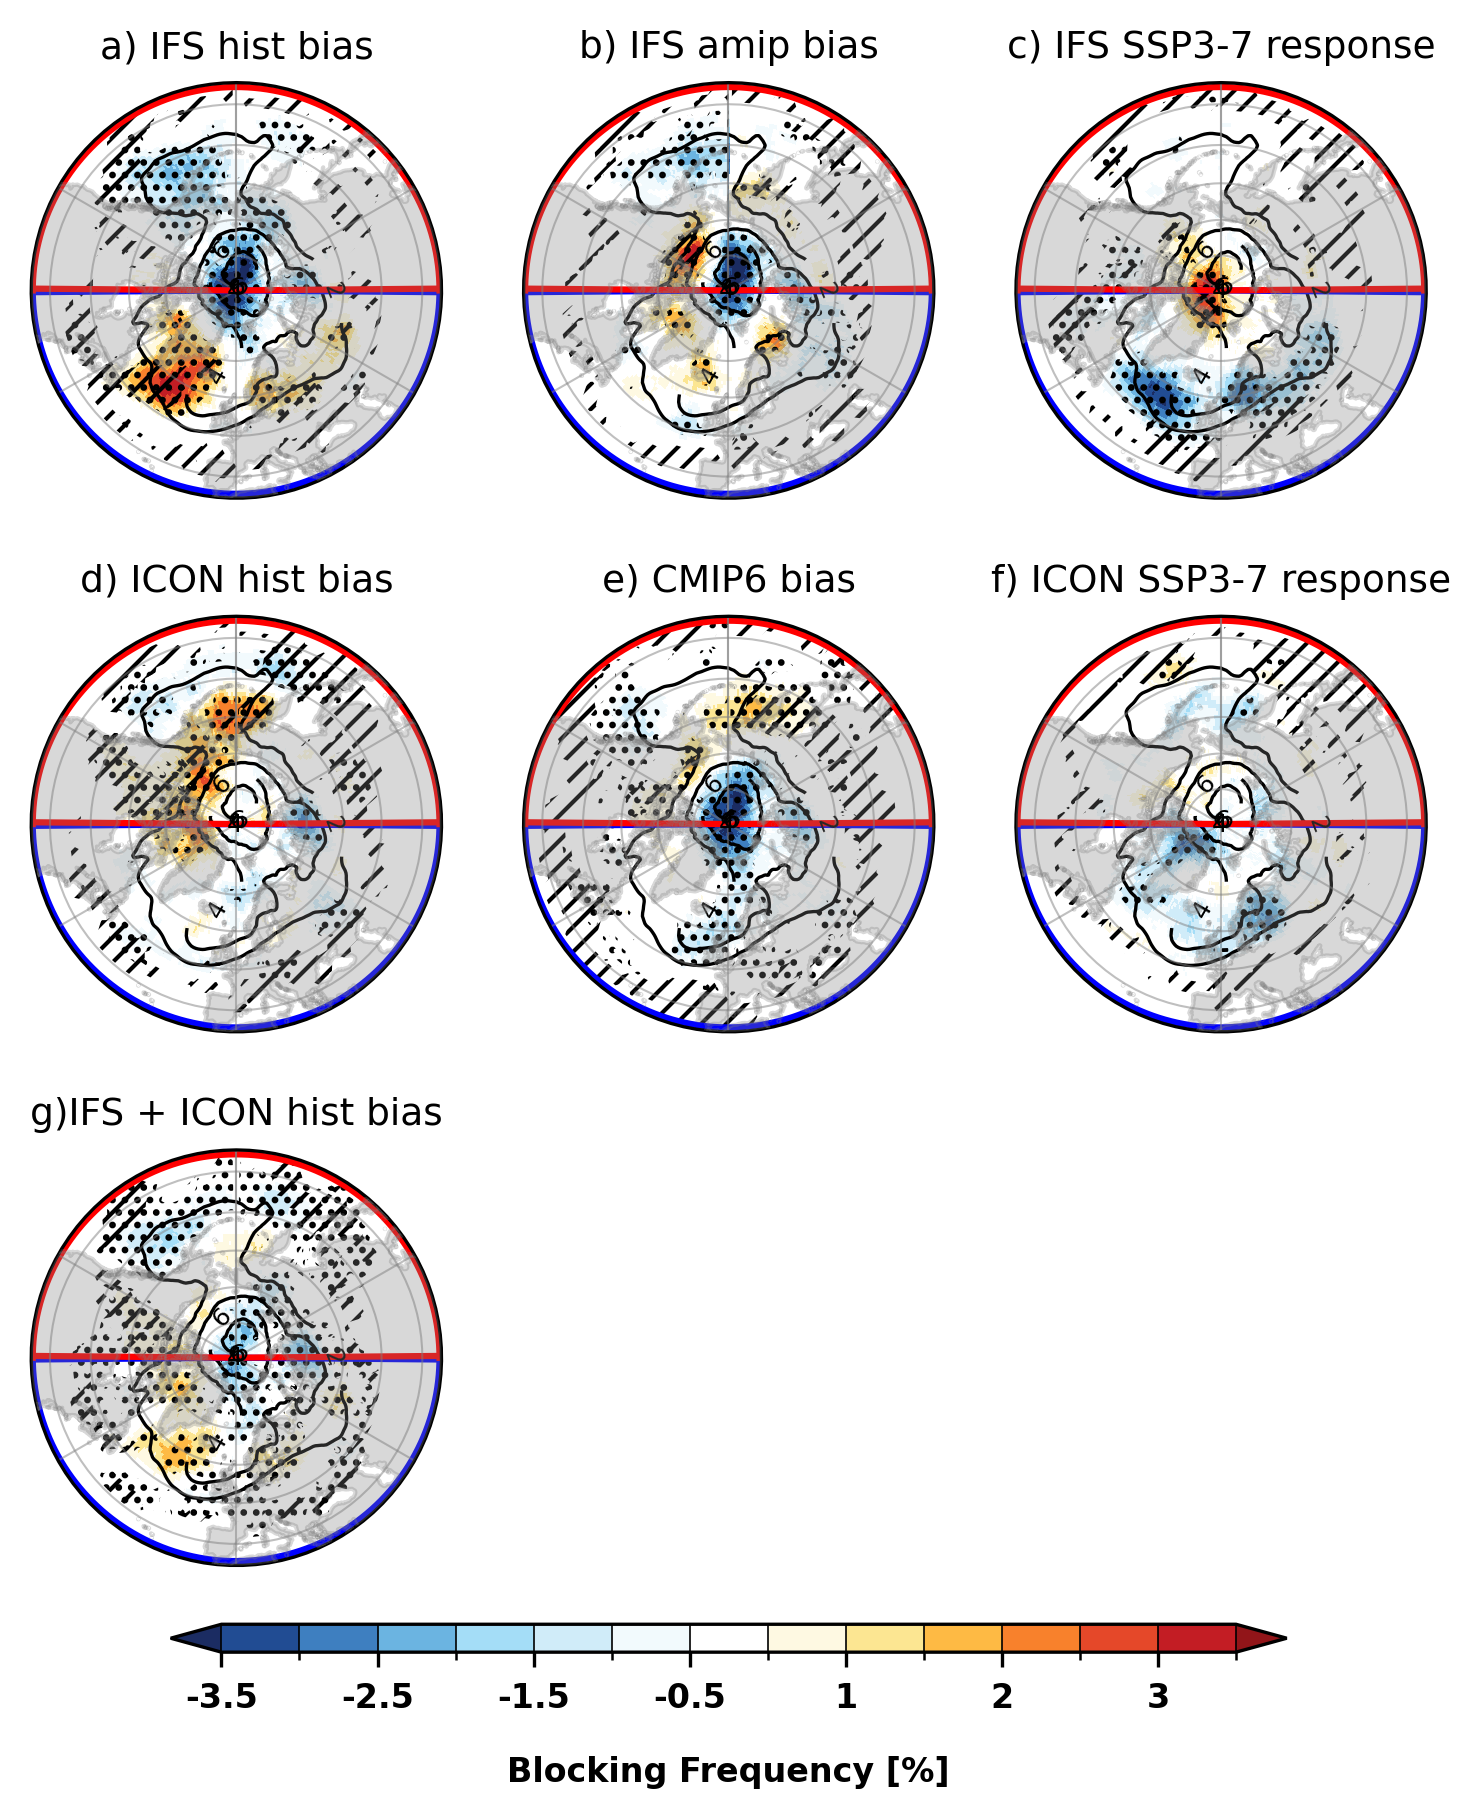

In [34]:
### Hemisphere selection
#hemisphere = 'SH'  # 'NH' or 'SH'

### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12, 14]
contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

if hemisphere == 'NH': 
    if sufix == 'DJF':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]
    if sufix == 'JJA':
        main_levels = [2, 4, 6, 8, 10, 12, 14]
        contour_levels = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
if hemisphere == 'SH':     
    if sufix == 'DJF':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]
    if sufix == 'JJA':
        main_levels = [4, 8, 12, 16, 20]
        contour_levels = [-5, -4,-3, -2, -1,  1,2,3,4,5]

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


### Define figure and axes
#fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=300, subplot_kw={'projection': proj})
fig, axes = plt.subplots(3, 3, figsize=(6, 8), dpi=300, subplot_kw={'projection': proj})

### Define data and titles acc_icon_fut, acc_era5, 
### ifs_hist2_bias --> bias_ifs, 
### bias_ifs_rel -->ifs_hist2_bias_rel
###  sig_ifs_his --> sig_ifs_hist2
data_list = [ifs_his_bias, ifs_amip_bias, ifs_chgs, icon_his_bias,bias_cmip6,icon_chgs,kms_bias]
data_rel = [ifs_his_bias_rel, ifs_amip_bias_rel, ifs_chgs_rel, icon_his_bias_rel, bias_cmip6_rel,icon_chgs_rel,kms_bias_rel]
data_sig = [sig_ifs_his, sig_ifs_amip,sig_ifs_chgs, sig_icon_his, sig_cmip6, sig_icon_chgs, sig_sr_chgs]
titles = ['a) IFS hist bias','b) IFS amip bias', 'c) IFS SSP3-7 response', 'd) ICON hist bias', 'e) CMIP6 bias', 'f) ICON SSP3-7 response','g)IFS + ICON hist bias']
cmaps = [ cpt_convert,cpt_convert, cpt_convert, cpt_convert, cpt_convert, cpt_convert, cpt_convert]
extend_modes = ['both', 'both','both', 'both', 'both', 'both', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

plot=None
### Loop through subplots
for ax, data, rel, significant, title, cmap, extend in zip(axes.flatten(), data_list, data_rel,data_sig, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels= contour_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using ERA5 as a reference
    contour = ax.contour(clon, acc_era5.lat, acc_era5_new, colors='k', linewidths=0.8, 
                                    levels=main_levels, transform=ccrs.PlateCarree())    
    ax.clabel(contour, fontsize=6, inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )

    # Ensure the mask is binary (1 for True, 0 for False)
    significant_mask = significant.astype(int)
    density=4
    ax.contourf(
        significant_mask.lon, significant_mask.lat, significant_mask,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'.',density*'.'],
        )
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
   
##    # North Atlantic: lon -85 to 85, lat 0 to 90
    atlantic_lons = [-89.5, 89.5, 89.5, -89.5, -89.5]
    atlantic_lats = [0, 0, 90, 90, 0]
    ax.plot(atlantic_lons, atlantic_lats, transform=ccrs.PlateCarree(),
        color='blue', linewidth=1.5, linestyle='-', label='North Atlantic')

    draw_semicircle(ax, center_lat=90, radius_deg=54, lon_start=-90, lon_end=90,
                color='blue', linewidth=1.5, linestyle='-')

## North Pacific: lon 95 to 180 and -180 to -95
## Pacific box as a continuous closed path
    pacific_lons = [90.5, 180, -180, -90.5, 90.5]
    pacific_lats = [0, 0, 0, 0, 0]  # bottom side
    ax.plot(pacific_lons, pacific_lats, transform=ccrs.PlateCarree(),
        color='red', linewidth=1.5, linestyle='-')

    pacific_lons = [90.5, 90.5, -90.5, -90.5, 90.5]
    pacific_lats = [0, 90, 90, 0, 0]  # sides and top
    ax.plot(pacific_lons, pacific_lats, transform=ccrs.PlateCarree(),
        color='red', linewidth=1.5, linestyle='-')

    draw_semicircle(ax, center_lat=90, radius_deg=54, lon_start=90, lon_end=270,
                color='red', linewidth=1.5, linestyle='-')

    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)

# Hide unused axes
for ax in axes.flatten()[len(data_list):]:
    ax.set_visible(False)
    
### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

### Save figure
plt.savefig(f'km-scale_block_bias_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [35]:
### ABSOLUTE VALUES
'''
hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=150, subplot_kw={'projection': proj})

### Define data and titles acc_icon_fut, acc_era5, block_cmip6, acc_ifs_his
data_list = [acc_ifs_his, acc_ifs_amip, acc_ifs_fut, acc_icon_his, acc_icon_fut, block_cmip6]
titles = ['a) IFS hist','b) IFS amip', 'c) IFS SSP3-7', 'd) ICON hist','e) ICON SSP3-7', 'f) CMIP6 x8']
cmaps = ['Oranges'] * 6
extend_modes = ['max'] * 6

### Loop through subplots
plots = []  # To store the plot objects for colorbar
for ax, data, title, cmap, extend in zip(axes.flatten(), data_list, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels=main_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)  # No individual colorbars
    plots.append(plot)  # Store the plot object for the colorbar

    # Contours using ERA5 as a reference
    acc_era5.plot.contour(ax=ax, colors='k', linewidths=0.8, levels=main_levels, transform=ccrs.PlateCarree())
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)

### Colorbar
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(main_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)

### Adjust layout to fit the colorbar
plt.subplots_adjust(bottom=0.25)
'''

'\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstack([np.sin(theta), np.cos(theta)]).T\ncircle = mpath.Path(verts * radius + center)\n\n### Define figure and axes\nfig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=150, subplot_kw={\'projection\': proj})\n\n### Define data and titles acc_icon_fut, acc_era5, block_cmip6, acc_ifs_his\ndata_list = [acc_ifs_his, acc_ifs_amip, acc_ifs_fut, acc_icon_his, acc_icon_fut, block_cmip6]\ntitles = [\'a) IFS hist\',\'b) IFS amip\', \'c) IFS SSP3-7\', \'d) ICON hist\',\'e) ICON SSP3-7\', \'f) CMIP6 x8\']\nc

In [36]:
### Including KM-scale ensemble (g)
#icon_interp = icon_his_bias.interp(lon=ifs_his_bias.lon) # Interpolate ICON to IFS grid
#kms_bias.plot() #= (ifs_his_bias + icon_interp).mean(axis=0)
#(icon_interp+ifs_his_bias)/2

In [37]:
#Trends

<xarray.DataArray (time: 30)>
array([1990.99657769, 1991.99657769, 1992.99931554, 1993.99657769,
       1994.99657769, 1995.99657769, 1996.99931554, 1997.99657769,
       1998.99657769, 1999.99657769, 2000.99931554, 2001.99657769,
       2002.99657769, 2003.99657769, 2004.99931554, 2005.99657769,
       2006.99657769, 2007.99657769, 2008.99931554, 2009.99657769,
       2010.99657769, 2011.99657769, 2012.99931554, 2013.99657769,
       2014.99657769, 2015.99657769, 2016.99931554, 2017.99657769,
       2018.99657769, 2019.99657769])
Coordinates:
  * time     (time) datetime64[ns] 1990-12-31 1991-12-31 ... 2019-12-31


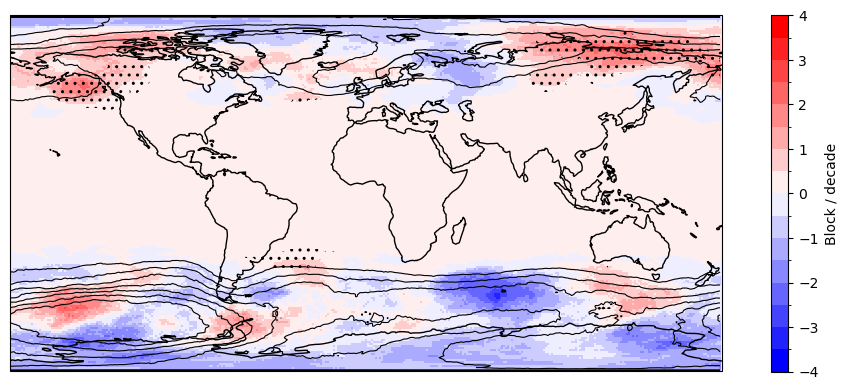

In [38]:
### Trends
from scipy.stats import linregress

# write our own function to get DataArrays with the results
def get_trend(xx: np.ndarray, yy: np.ndarray) -> (xr.DataArray, xr.DataArray, xr.DataArray):
    """Fit linear trend and p-value.

    Parameters
    ----------
    xx : np.ndarray, shape (N,)
    yy : np.ndarray, shape (N,)

    Returns
    -------
    tuple of DataArray : (slope, intercept, pvalue)
    """
    results = linregress(xx, yy, alternative='greater')  # only look for statistically significant positive trends
    return (
        xr.DataArray(results.slope, name='slope'),
        xr.DataArray(results.intercept, name='intercept'),
        xr.DataArray(results.pvalue, name='pvalue'),
        
    )

### Yearly blocking number
#block_year=xr.where(blocks_era5['flag']>1,1,0)
#block_year=xr.where(blocks_ifs_his['flag']>1,1,0)
#block_year=xr.where(blocks_icon_his['flag']>1,1,0)
block_year=xr.where(blocks_ifs_amip['flag']>1,1,0)
#block_year=xr.where(blocks_ifs_fut['flag']>1,1,0)
#block_year=xr.where(blocks_icon_fut['flag']>1,1,0)
#block_year=xr.where(blocks_cmip6_tmp['flag']>1,1,0)
block_year=block_year.resample(time='1Y').sum()

'''
results = xr.apply_ufunc(
    get_trend,
    block_year['time'], block_year,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], []],
    vectorize=True,
)
'''

# Convert time to float years
time_in_years = block_year['time'].dt.year + (block_year['time'].dt.dayofyear - 1) / 365.25
print(time_in_years)

results = xr.apply_ufunc(
    get_trend,
    time_in_years, block_year,
#    block_year['time'], block_year,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], []],
    vectorize=True,
)


ds = xr.Dataset(
    {'slope': results[0],
     'intercept': results[1],
     'pvalue': results[2],
    })
ds

fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
(ds['slope'] * 10).plot.pcolormesh(ax=ax, cmap='bwr', levels=np.arange(-4.0, 4.1, .5), cbar_kwargs={'label': 'Block / decade'})

ax.contourf(
    ds['lon'], ds['lat'], (ds['pvalue'] < .05),  # stipple positive trends at a 1% level
    transform=ccrs.PlateCarree(),
    levels=[.5, 1.5],
    colors='none',
    hatches=['..'],
)
acc_era5.plot.contour(ax=ax, colors='k', linewidths=0.8, levels=main_levels, transform=ccrs.PlateCarree())
ax.coastlines()
#ax.set_title('Number of blocks in the year {}-{} trend'.format(tasmax_eu['time'][0].item(), tasmax_eu['time'][-1].item()))
fig.tight_layout()

## Tracks

### IFS Trends

In [39]:
################################
# Get CSV files list from a folder
#path = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z5002'
path = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_Z500_90th'

###one file
#ifs_df = pd.read_csv(path+'/BLOCKS-ifs-production-1990-2019.csv')

### multiple files

csv_files = sorted(glob.glob(path + "/*.csv"))

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)


#Loop to resample the flag 
accumulator = []
adj=0
for df in df_list:
    df['Flag']=df['Flag']+adj
    adj=df['Flag'].iloc[-1]

    accumulator.append(df)
    
ifs_df = pd.concat(accumulator)

ifs_df['year']=ifs_df.Date.str[:4]

In [40]:
### Analysis

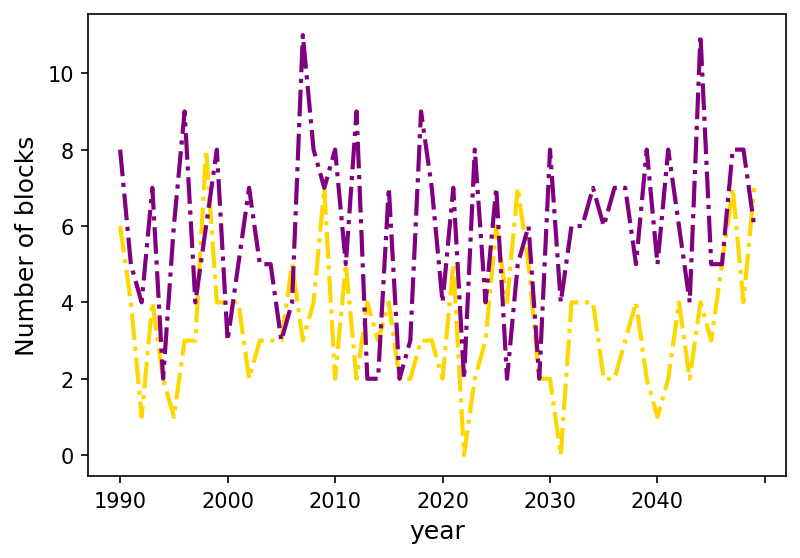

In [41]:
### take values in the northern hemosphere lat > 0
#ifs_df_td = ifs_df[(ifs_df['Latitude'] > 0 )]
###print(era5_df['Flag'].iloc[-1],icon_ngc2013_df['Flag'].iloc[-1],icon_ngc3028_df['Flag'].iloc[-1],IFS_4_FESOM_5_df['Flag'].iloc[-1],IFS_28_NEMO_25_df['Flag'].iloc[-1],cmip6_df['Flag'].iloc[-1])
##print(ifs_df['Flag'].nunique())
##print(ifs_df['Date'].nunique())

### Plotting 
### regions 
###xy=[5, 40], width=40, height=25,
###xy=[160, 50], width=30, height=25

### NA                                
ifs_df_na = ifs_df[(ifs_df['Latitude'] > 40 ) & (ifs_df['Latitude'] < 65 ) & (ifs_df['Longitude'] > 5 ) & (ifs_df['Longitude'] < 40 )]
### NP 
ifs_df_np = ifs_df[(ifs_df['Latitude'] > 50 ) & (ifs_df['Latitude'] < 75 ) & (ifs_df['Longitude'] > 160 ) & (ifs_df['Longitude'] < 180 )]
#ifs_df_td = ifs_df[(ifs_df['Latitude'] > 50 ) & (ifs_df['Latitude'] < 75 ) & (ifs_df['Longitude'] > 160 ) ]

##
# Get the complete list of years
all_years = ifs_df['year'].unique()
# Group by 'year' and count unique 'Flag' values
ifs_np = ifs_df_np.groupby('year')['Flag'].nunique()
ifs_na = ifs_df_na.groupby('year')['Flag'].nunique()
# Reindex to include all years, assigning NaN to those with no data
ifs_np = ifs_np.reindex(all_years, fill_value=0)
ifs_na = ifs_na.reindex(all_years, fill_value=0)
##

###Fit function
x_np=np.arange(ifs_np.size)
fit=np.polyfit(x_np,ifs_np.values,1)
fit_fn_np=np.poly1d(fit)
x_na=np.arange(ifs_na.size)
fit=np.polyfit(x_na,ifs_na.values,1)
fit_fn_na=np.poly1d(fit)

### Plot
fig,ax=plt.subplots(figsize=(6, 4), dpi=150)
ifs_np.plot(color='gold', linestyle='-.',lw=2)
#plt.plot(ifs_np.index,fit_fn_np(x_np),color='purple',linestyle='-',lw=2)
ifs_na.plot(color='purple', linestyle='-.',lw=2)
#plt.plot(ifs_np.index,fit_fn_na(x_na)[0:-1],color='gold',linestyle='-',lw=2)
plt.ylabel('Number of blocks', fontsize=12)
plt.xlabel('year',fontsize=12)
#ax.xaxis.set_tick_params(labelsize=17)
#ax.yaxis.set_tick_params(labelsize=17)
plt.savefig('IFS-production_trend.png',bbox_inches='tight')

In [42]:
### Finding intense blockings
#ifs_yy.index

#years=pd.to_numeric(icon_np.index, errors='coerce')
#years
#icon_np.values
'''
import pandas as pd
###2021
block_df = pd.read_csv('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z5002/BLOCKS-ifs-production-2040-2049.csv', delimiter=',',header=0)
###2022
#block_df =  pd.read_csv('/work/bm1235/b382006/regridding/cycle3/ngc3028/block/ANO_Z500/BLOCKS-icon-ngc3028-2022.csv', delimiter=',',header=0)
### Find bid (flag of most intense blockings) 
block_df.loc[block_df['Intensity'].nlargest(35).index]

#bid=9530
#bid=3117
bid=6908

mdate = timb[0:4] + timb[5:7] + timb[8:10] + '_' + timb[11:13]
lonts = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
latts = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])
dates = np.asarray(block_df['Date'].iloc[np.where(block_df['Flag']==bid)]) #'20210326_12'
lonts[lonts <= 0] = lonts+360
dates

print(mdate)
#2044-01-16T12:00
block_df['Flag'].iloc[np.where(block_df['Date']==mdate)]
'''

"\nimport pandas as pd\n###2021\nblock_df = pd.read_csv('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z5002/BLOCKS-ifs-production-2040-2049.csv', delimiter=',',header=0)\n###2022\n#block_df =  pd.read_csv('/work/bm1235/b382006/regridding/cycle3/ngc3028/block/ANO_Z500/BLOCKS-icon-ngc3028-2022.csv', delimiter=',',header=0)\n### Find bid (flag of most intense blockings) \nblock_df.loc[block_df['Intensity'].nlargest(35).index]\n\n#bid=9530\n#bid=3117\nbid=6908\n\nmdate = timb[0:4] + timb[5:7] + timb[8:10] + '_' + timb[11:13]\nlonts = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])\nlatts = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])\ndates = np.asarray(block_df['Date'].iloc[np.where(block_df['Flag']==bid)]) #'20210326_12'\nlonts[lonts <= 0] = lonts+360\ndates\n\nprint(mdate)\n#2044-01-16T12:00\nblock_df['Flag'].iloc[np.where(block_df['Date']==mdate)]\n"

### Blocking properties present-day

In [43]:
#### Select domain and period
domain='ATL' ### PAC, ATL, NH
sufix='DJF' ### YEAR, DJF, JJA
anom_version='ANO_Z500_90th'

In [44]:
# Get CSV files list from a folder
###IFS HIS
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/'+anom_version+'/BLOCKS-ifs-production-1990-2019.csv'
ifs_his = pd.read_csv(file)
ifs_his['year']=ifs_his.Date.str[:4]
ifs_his['month']=ifs_his.Date.str[4:6]

###IFS FUT
file = "/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/"+anom_version+"/BLOCKS-ifs-production-2020-2049.csv"
ifs_fut = pd.read_csv(file)
ifs_fut['year']=ifs_fut.Date.str[:4]
ifs_fut['month']=ifs_fut.Date.str[4:6]

###IFS AMIP
file = "/scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/"+anom_version+"/BLOCKS-ifs-production-1990-2019.csv"
ifs_amip = pd.read_csv(file)
ifs_amip['year']=ifs_amip.Date.str[:4]
ifs_amip['month']=ifs_amip.Date.str[4:6]

### ICON HIS
file = "/scratch/b/b382006/icon-climate-dt/block/"+anom_version+"/BLOCKS-icon-ngc4008-1993-2019.csv"
icon_his = pd.read_csv(file)
icon_his['year']=icon_his.Date.str[:4]
icon_his['month']=icon_his.Date.str[4:6]

### ICON FUT
file = "/scratch/b/b382006/nextgems/prefinal/ngc4008/block/"+anom_version+"/BLOCKS-icon-ngc4008-2025-2049.csv"
icon_fut = pd.read_csv(file)
icon_fut['year']=icon_fut.Date.str[:4]
icon_fut['month']=icon_fut.Date.str[4:6]

##ERA5
file = '/scratch/b/b382006/obs/era5/block/'+anom_version+'/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]

### filter domain
if domain == 'NH':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & (ifs_his['Longitude'] > -90 ) & (ifs_his['Longitude'] < 90 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 ) & (ifs_amip['Longitude'] > -90 ) & (ifs_amip['Longitude'] < 90 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & (ifs_fut['Longitude'] > -90 ) & (ifs_fut['Longitude'] < 90 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & (icon_his['Longitude'] > -90 ) & (icon_his['Longitude'] < 90 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & (icon_fut['Longitude'] > -90 ) & (icon_fut['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & ((ifs_his['Longitude'] > 90 ) | (ifs_his['Longitude'] < -90 ))]
    ifs_amip = ifs_amip[(ifs_his['Latitude'] > 0 ) & ((ifs_amip['Longitude'] > 90 ) | (ifs_amip['Longitude'] < -90 ))]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & ((ifs_fut['Longitude'] > 90 ) | (ifs_fut['Longitude'] < -90 ))]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & ((icon_his['Longitude'] > 90 ) | (icon_his['Longitude'] < -90 ))]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & ((icon_fut['Longitude'] > 90 ) | (icon_fut['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")

ifs_his = ifs_his[ifs_his['month'].isin(months)]
ifs_amip = ifs_amip[ifs_amip['month'].isin(months)]
ifs_fut = ifs_fut[ifs_fut['month'].isin(months)]
icon_his = icon_his[icon_his['month'].isin(months)]
icon_fut = icon_fut[icon_fut['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]
    
### LOAD CMIP6 models
models = [
    'MRI-ESM2-0',
    'ACCESS-CM2',
    'EC-Earth3',
    'MPI-ESM1-2-HR',
    'CESM2-WACCM', 
    'MIROC6',
    'MPI-ESM1-2-LR',
    'CESM2'
]

base_path = '/scratch/b/b382006/cmip6/historical/'

# Initialize an empty list to collect the arrays
all_values = []

# Loop through each model and process its data
for model in models:
    if model=='MRI-ESM2-0':
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1969-2000.csv'
    elif model=='CESM2':
        file = f'{base_path}{model}/r11i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    else:
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    cmip_df = pd.read_csv(file)
    cmip_df['year'] = cmip_df['Date'].str[:4]
    cmip_df['month']= cmip_df.Date.str[4:6]

    ### filter domain
    if domain == 'NH':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0 )]
    if domain == 'ATL':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & (cmip_df['Longitude'] > -90 ) & (cmip_df['Longitude'] < 90 )]
    if domain == 'PAC':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & ((cmip_df['Longitude'] > 90 ) | (cmip_df['Longitude'] < -90 ))]

### filter time
    cmip_df = cmip_df[cmip_df['month'].isin(months)] 

    ### count unique values here due to repeated flags in each model
    unique_flags = cmip_df.groupby('year')['Flag'].nunique().values
    all_values.append(unique_flags)

# Concatenate all arrays into a single array
cmip_dfs = np.concatenate(all_values)

### Prepare to plot
# Color definitions
color_ifs = '#68ab67'
color_icon = '#6b64ff'
color_era5 = 'darkgrey'
color_cmip6 = '#db6f30'

# Sample DataFrame simulation
# Replace this with your actual DataFrame values
era5_values = era5_df.groupby('year')['Flag'].nunique().values
ifs_his_values = ifs_his.groupby('year')['Flag'].nunique().values
ifs_amip_values = ifs_amip.groupby('year')['Flag'].nunique().values
ifs_fut_values = ifs_fut.groupby('year')['Flag'].nunique().values
icon_his_values = icon_his.groupby('year')['Flag'].nunique().values
icon_fut_values = icon_fut.groupby('year')['Flag'].nunique().values

data = [era5_values, ifs_his_values,ifs_amip_values, icon_his_values, cmip_dfs, ifs_fut_values,icon_fut_values]
labels = ['ERA5', 'IFS hist','IFS amip','ICON hist','CMIP6','IFS SSP3-7','ICON SSP3-7']
colors = [color_era5, color_ifs,color_ifs,color_icon,color_cmip6, color_ifs,  color_icon]

    Simulation  p-value (Mann-Whitney)  KL divergence (sim || ERA5)
0     IFS hist                0.024766                     0.686633
1     IFS amip                0.765111                     0.608361
2    ICON hist                0.000001                     3.088149
3        CMIP6                0.631997                     0.495422
4   IFS SSP3-7                0.043962                     0.497809
5  ICON SSP3-7                0.000113                     1.905266


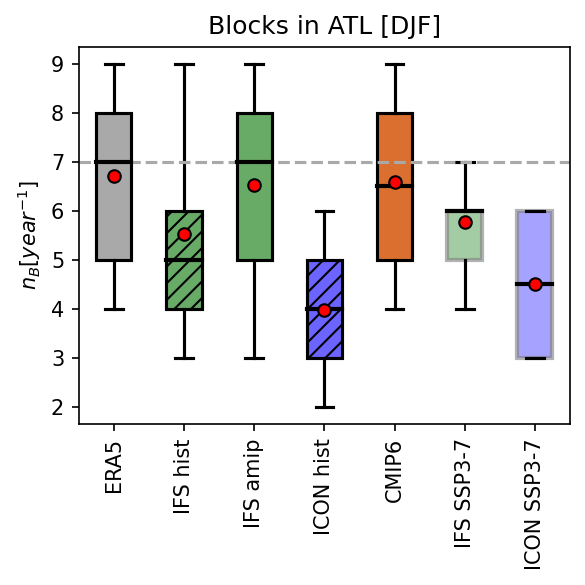

In [45]:
# === Load your blocking counts and compute signifiance
# Organize into a dictionary for easy loop
data_dic = {
    'ERA5': era5_values,
    'IFS hist': ifs_his_values,
    'IFS amip': ifs_amip_values,
    'ICON hist': icon_his_values,
    'CMIP6': cmip_dfs,
    'IFS SSP3-7': ifs_fut_values,
    'ICON SSP3-7': icon_fut_values,
}

# Target (reference) dataset
reference = 'ERA5'

# Storage for results
results = {
    'Simulation': [],
    'p-value (Mann-Whitney)': [],
    'KL divergence (sim || ERA5)': []
}

# Define common bin edges for histograms (important for KL divergence)
# You can adjust the number of bins depending on your data
max_val = max([np.max(vals) for vals in data_dic.values()])
bins = np.linspace(0, max_val + 5, 20)  # Add small margin

# Loop over all models (except ERA5 vs ERA5)
for label, values in data_dic.items():
    if label == reference:
        continue

    # === Mann-Whitney U Test (median differences) ===
    stat, p_value = mannwhitneyu(values, data_dic[reference], alternative='two-sided')

    # === KL Divergence (distribution distance) ===
    hist_model, _ = np.histogram(values, bins=bins, density=True)
    hist_ref, _ = np.histogram(data_dic[reference], bins=bins, density=True)

    # Avoid division by zero
    hist_model = np.where(hist_model == 0, 1e-8, hist_model)
    hist_ref = np.where(hist_ref == 0, 1e-8, hist_ref)

    kl_div = entropy(hist_model, hist_ref)

    # === Store results ===
    results['Simulation'].append(label)
    results['p-value (Mann-Whitney)'].append(p_value)
    results['KL divergence (sim || ERA5)'].append(kl_div)

# Create a pandas DataFrame
results_df = pd.DataFrame(results)

# Print nicely
print(results_df)

# Optional: save table to CSV if you want
# results_df.to_csv('blocking_metrics_table.csv', index=False)

# First, set up a mapping from simulation name to p-value
pval_map = dict(zip(results_df['Simulation'], results_df['p-value (Mann-Whitney)']))

# Now, create the p-values list for plotting, matching 'labels' order
p_values = []
for label in labels:
    if label == 'ERA5':
        p_values.append(np.nan)  # No p-value for ERA5
    else:
        p_values.append(pval_map.get(label, np.nan))  # Safely get p-value or NaN if missing

#print(p_values)

# Plot boxplot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True,showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Rotate x-axis labels 
plt.xticks(rotation=90)

## Custom colors and hatches for significant models
#for patch, color, pval in zip(bplot['boxes'], colors, p_values):
#    patch.set_facecolor(color)
#    if not np.isnan(pval) and pval < 0.05:
#        patch.set_hatch('///')  # or '...' or 'xx' as hatch style
#        patch.set_edgecolor('black')  # Make it more visible
#    else:
#        patch.set_alpha(0.7)  # Slightly transparent if not significant
# Define which labels are future scenarios (for styling)
future_labels = ['IFS SSP3-7', 'ICON SSP3-7']

for patch, label, color, pval in zip(bplot['boxes'], labels, colors, p_values):
    patch.set_facecolor(color)
    
    if label in future_labels:
        # Style SSP3-7.0 boxes differently
        patch.set_edgecolor('gray')
        patch.set_linewidth(2)
        patch.set_alpha(0.6)  # faded appearance
    else:
        # Historical/AMIP: apply significance hatching if needed
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        if not np.isnan(pval) and pval < 0.05:
            patch.set_hatch('///')

# Calculate and add a horizontal line at the mean of era5
mean_era5 = np.median(era5_values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Median ({mean_era5:.2f})')


ax.set_ylabel('$n_{B}$[$year^{-1}$]')
ax.set_title('Blocks in '+domain+' ['+sufix+']')

plt.tight_layout()
plt.savefig('km-scale_number-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [46]:
### Persistence

In [47]:
#### Select domain and period
domain='ATL' ### PAC, ATL, NH
sufix='JJA' ### YEAR, DJF, JJA
anom_version='ANO_Z500_90th'

# Get CSV files list from a folder
###IFS HIS
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/'+anom_version+'/BLOCKS-ifs-production-1990-2019.csv'
ifs_his = pd.read_csv(file)
ifs_his['year']=ifs_his.Date.str[:4]
ifs_his['month']=ifs_his.Date.str[4:6]
ifs_values = ifs_his.groupby('Flag').size().reset_index(name='Duration')
ifs_his = ifs_his.merge(ifs_values, on='Flag', how='left')

###IFS FUT
file = "/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/"+anom_version+"/BLOCKS-ifs-production-2020-2049.csv"
ifs_fut = pd.read_csv(file)
ifs_fut['year']=ifs_fut.Date.str[:4]
ifs_fut['month']=ifs_fut.Date.str[4:6]
ifs_values = ifs_fut.groupby('Flag').size().reset_index(name='Duration')
ifs_fut = ifs_fut.merge(ifs_values, on='Flag', how='left')

###IFS AMIP
file = "/scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/"+anom_version+"/BLOCKS-ifs-production-1990-2019.csv"
ifs_amip = pd.read_csv(file)
ifs_amip['year']=ifs_amip.Date.str[:4]
ifs_amip['month']=ifs_amip.Date.str[4:6]
ifs_values = ifs_amip.groupby('Flag').size().reset_index(name='Duration')
ifs_amip = ifs_amip.merge(ifs_values, on='Flag', how='left')

### ICON HIS
file = "/scratch/b/b382006/icon-climate-dt/block/"+anom_version+"/BLOCKS-icon-ngc4008-1993-2019.csv"
icon_his = pd.read_csv(file)
icon_his['year']=icon_his.Date.str[:4]
icon_his['month']=icon_his.Date.str[4:6]
icon_values = icon_his.groupby('Flag').size().reset_index(name='Duration')
icon_his = icon_his.merge(icon_values, on='Flag', how='left')

### ICON FUT
file = "/scratch/b/b382006/nextgems/prefinal/ngc4008/block/"+anom_version+"/BLOCKS-icon-ngc4008-2025-2049.csv"
icon_fut = pd.read_csv(file)
icon_fut['year']=icon_fut.Date.str[:4]
icon_fut['month']=icon_fut.Date.str[4:6]
icon_values = icon_fut.groupby('Flag').size().reset_index(name='Duration')
icon_fut = icon_fut.merge(icon_values, on='Flag', how='left')

##ERA5
file = '/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
era5_values = era5_df.groupby('Flag').size().reset_index(name='Duration')
era5_df = era5_df.merge(era5_values, on='Flag', how='left')

### filter domain
if domain == 'NH':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & (ifs_his['Longitude'] > -90 ) & (ifs_his['Longitude'] < 90 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 ) & (ifs_amip['Longitude'] > -90 ) & (ifs_amip['Longitude'] < 90 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & (ifs_fut['Longitude'] > -90 ) & (ifs_fut['Longitude'] < 90 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & (icon_his['Longitude'] > -90 ) & (icon_his['Longitude'] < 90 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & (icon_fut['Longitude'] > -90 ) & (icon_fut['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & ((ifs_his['Longitude'] > 90 ) | (ifs_his['Longitude'] < -90 ))]
    ifs_amip = ifs_amip[(ifs_his['Latitude'] > 0 ) & ((ifs_amip['Longitude'] > 90 ) | (ifs_amip['Longitude'] < -90 ))]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & ((ifs_fut['Longitude'] > 90 ) | (ifs_fut['Longitude'] < -90 ))]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & ((icon_his['Longitude'] > 90 ) | (icon_his['Longitude'] < -90 ))]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & ((icon_fut['Longitude'] > 90 ) | (icon_fut['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")

ifs_his = ifs_his[ifs_his['month'].isin(months)]
ifs_amip = ifs_amip[ifs_amip['month'].isin(months)]
ifs_fut = ifs_fut[ifs_fut['month'].isin(months)]
icon_his = icon_his[icon_his['month'].isin(months)]
icon_fut = icon_fut[icon_fut['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]

### keep only unique flags
ifs_his_values = ifs_his.drop_duplicates(subset=['Flag']).reset_index(drop=True)
ifs_fut_values = ifs_fut.drop_duplicates(subset=['Flag']).reset_index(drop=True)
ifs_amip_values = ifs_amip.drop_duplicates(subset=['Flag']).reset_index(drop=True)
icon_his_values = icon_his.drop_duplicates(subset=['Flag']).reset_index(drop=True)
icon_fut_values = icon_fut.drop_duplicates(subset=['Flag']).reset_index(drop=True)
era5_values = era5_df.drop_duplicates(subset=['Flag']).reset_index(drop=True)


# Initialize an empty list to collect the arrays
all_values = []
base_path = '/scratch/b/b382006/cmip6/historical/'

# Loop through each model and process its data
for model in models:
    if model=='MRI-ESM2-0':
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1969-2000.csv'
    elif model=='CESM2':
        file = f'{base_path}{model}/r11i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    else:
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    cmip_df = pd.read_csv(file)
    cmip_df['year'] = cmip_df['Date'].str[:4]
    cmip_df['month']= cmip_df.Date.str[4:6]
    cmip_values = cmip_df.groupby('Flag').size().reset_index(name='Duration')
    cmip_df = cmip_df.merge(cmip_values, on='Flag', how='left')

    ### filter domain
    if domain == 'NH':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0 )]
    if domain == 'ATL':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & (cmip_df['Longitude'] > -90 ) & (cmip_df['Longitude'] < 90 )]
    if domain == 'PAC':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & ((cmip_df['Longitude'] > 90 ) | (cmip_df['Longitude'] < -90 ))]

### filter time
    cmip_df = cmip_df[cmip_df['month'].isin(months)] 

###====
    unique_flags= cmip_df.drop_duplicates(subset=['Flag']).reset_index(drop=True)
    all_values.append(unique_flags)

# Concatenate all DataFrames into a single DataFrame
cmip_dfs = pd.concat(all_values).reset_index()
#####=====

###

data = [era5_values['Duration'].values, ifs_his_values['Duration'].values,
        ifs_amip_values['Duration'].values,icon_his_values['Duration'].values,
        cmip_dfs['Duration'].values,ifs_fut_values['Duration'].values, icon_fut_values['Duration'].values]

labels = ['ERA5', 'IFS hist','IFS amip','ICON hist','CMIP6','IFS SSP3-7','ICON SSP3-7']
colors = [color_era5, color_ifs,color_ifs,color_icon,color_cmip6, color_ifs,  color_icon]


    Simulation  p-value (Mann-Whitney)  KL divergence (sim || ERA5)
0     IFS hist                0.809472                     0.114629
1     IFS amip                0.281223                     0.050999
2    ICON hist                0.239256                     0.509387
3        CMIP6                0.814286                     0.180362
4   IFS SSP3-7                0.328518                     0.375735
5  ICON SSP3-7                0.339784                     0.463997


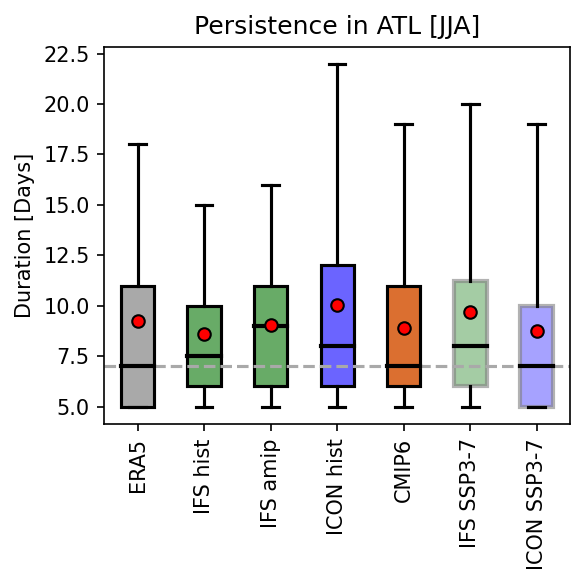

In [48]:
# Organize data into a dictionary
data_dic = {
    'ERA5': era5_values['Duration'].values,
    'IFS hist': ifs_his_values['Duration'].values,
    'IFS amip': ifs_amip_values['Duration'].values,
    'ICON hist': icon_his_values['Duration'].values,
    'CMIP6': cmip_dfs['Duration'].values,
    'IFS SSP3-7': ifs_fut_values['Duration'].values,
    'ICON SSP3-7': icon_fut_values['Duration'].values,
}

# Target (reference)
reference = 'ERA5'

# Storage for results
results = {
    'Simulation': [],
    'p-value (Mann-Whitney)': [],
    'KL divergence (sim || ERA5)': []
}

# Define common bins for histograms
max_val = max([np.max(vals) for vals in data_dic.values()])
bins = np.linspace(0, max_val + 5, 20)

# Compute metrics
for label, values in data_dic.items():
    if label == reference:
        continue

    stat, p_value = mannwhitneyu(values, data_dic[reference], alternative='two-sided')
    hist_model, _ = np.histogram(values, bins=bins, density=True)
    hist_ref, _ = np.histogram(data_dic[reference], bins=bins, density=True)

    hist_model = np.where(hist_model == 0, 1e-8, hist_model)
    hist_ref = np.where(hist_ref == 0, 1e-8, hist_ref)

    kl_div = entropy(hist_model, hist_ref)

    results['Simulation'].append(label)
    results['p-value (Mann-Whitney)'].append(p_value)
    results['KL divergence (sim || ERA5)'].append(kl_div)

# Create a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Map simulation names to p-values
pval_map = dict(zip(results_df['Simulation'], results_df['p-value (Mann-Whitney)']))

# Create p-values list for plotting, matching the 'labels' list
p_values = []
for label in labels:
    if label == 'ERA5':
        p_values.append(np.nan)
    else:
        p_values.append(pval_map.get(label, np.nan))


fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True, showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Rotate x-axis labels 
plt.xticks(rotation=90)

#for patch, color, pval in zip(bplot['boxes'], colors, p_values):
#    patch.set_facecolor(color)
#    if not np.isnan(pval) and pval < 0.05:
#        patch.set_hatch('///')  # Significant
#        patch.set_edgecolor('black')
#    else:
#        patch.set_alpha(0.7)  # Non-significant: slightly transparent
# Define which labels are future scenarios (for styling)
future_labels = ['IFS SSP3-7', 'ICON SSP3-7']

for patch, label, color, pval in zip(bplot['boxes'], labels, colors, p_values):
    patch.set_facecolor(color)
    
    if label in future_labels:
        # Style SSP3-7.0 boxes differently
        patch.set_edgecolor('gray')
        patch.set_linewidth(2)
        patch.set_alpha(0.6)  # faded appearance
    else:
        # Historical/AMIP: apply significance hatching if needed
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        if not np.isnan(pval) and pval < 0.05:
            patch.set_hatch('///')

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values['Duration'].values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Mean ({mean_era5:.2f})')


ax.set_ylabel('Duration [Days]')
ax.set_title('Persistence in '+domain+' ['+sufix+']')

plt.tight_layout()
plt.savefig('km-scale_duration-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

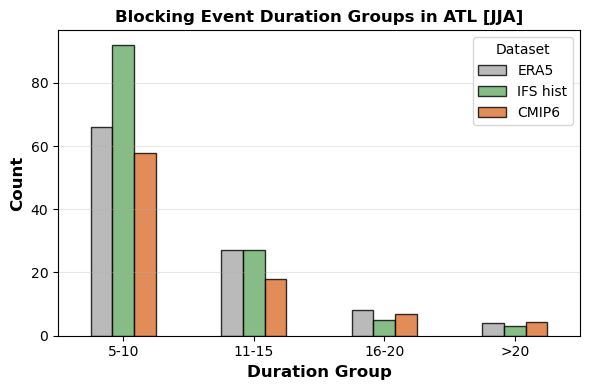

In [49]:
### Another example plot:
### Define bins and labels
bins = [5, 10, 15, 20, float('inf')]
labels = ['5-10', '11-15', '16-20', '>20']


## data = [era5_values['Duration'].values, ifs_values['Duration'].values, cmip_dfs['Duration'].values]

# Apply binning to each dataset
era5_values['Duration Group'] = pd.cut(era5_values['Duration'], bins=bins, labels=labels, right=True)
ifs_values['Duration Group'] = pd.cut(ifs_his_values['Duration'], bins=bins, labels=labels, right=True)
cmip_dfs['Duration Group'] = pd.cut(cmip_dfs['Duration'], bins=bins, labels=labels, right=True)

# Count occurrences in each group
era5_counts = era5_values['Duration Group'].value_counts().sort_index()
ifs_counts = ifs_values['Duration Group'].value_counts().sort_index()
cmip_counts = cmip_dfs['Duration Group'].value_counts().sort_index()


# Create a DataFrame to compare counts
duration_df = pd.DataFrame({'ERA5': era5_counts, 'IFS hist': ifs_counts,'CMIP6': cmip_counts}).fillna(0)

### mean of 8 cmip6
duration_df['CMIP6']= duration_df['CMIP6']/8

# Define hatching patterns (consistent for each dataset)
hatch_patterns = {'ERA5': None, 'IFS hist': None,'CMIP6': None}

# Plot grouped bar chart
ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_ifs, color_cmip6], alpha=0.8, edgecolor='black')

# Apply hatching consistently per dataset
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])  # Apply consistent hatching

plt.title('Blocking Event Duration Groups in ' + domain + ' [' + sufix + ']', fontsize=12, weight="bold")
plt.xlabel('Duration Group', fontsize=12, weight="bold")
plt.ylabel('Count', fontsize=12, weight="bold")
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()

#plt.savefig('duration-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [50]:
###### Size

In [51]:
#### Select domain and period
domain='PAC' ### PAC, ATL, NH
sufix='JJA' ### YEAR, DJF, JJA

# Get CSV files list from a folder
###IFS HIS
file = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/'+anom_version+'/BLOCKS-ifs-production-1990-2019.csv'
ifs_his = pd.read_csv(file)
ifs_his['year']=ifs_his.Date.str[:4]
ifs_his['month']=ifs_his.Date.str[4:6]
ifs_values = ifs_his.groupby('Flag').size().reset_index(name='Duration')
ifs_his = ifs_his.merge(ifs_values, on='Flag', how='left')

###IFS FUT
file = "/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/"+anom_version+"/BLOCKS-ifs-production-2020-2049.csv"
ifs_fut = pd.read_csv(file)
ifs_fut['year']=ifs_fut.Date.str[:4]
ifs_fut['month']=ifs_fut.Date.str[4:6]
ifs_values = ifs_fut.groupby('Flag').size().reset_index(name='Duration')
ifs_fut = ifs_fut.merge(ifs_values, on='Flag', how='left')

###IFS AMIP
file = "/scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/"+anom_version+"/BLOCKS-ifs-production-1990-2019.csv"
ifs_amip = pd.read_csv(file)
ifs_amip['year']=ifs_amip.Date.str[:4]
ifs_amip['month']=ifs_amip.Date.str[4:6]
ifs_values = ifs_amip.groupby('Flag').size().reset_index(name='Duration')
ifs_amip = ifs_amip.merge(ifs_values, on='Flag', how='left')

### ICON HIS
file = "/scratch/b/b382006/icon-climate-dt/block/"+anom_version+"/BLOCKS-icon-ngc4008-1993-2019.csv"
icon_his = pd.read_csv(file)
icon_his['year']=icon_his.Date.str[:4]
icon_his['month']=icon_his.Date.str[4:6]
icon_values = icon_his.groupby('Flag').size().reset_index(name='Duration')
icon_his = icon_his.merge(icon_values, on='Flag', how='left')

### ICON FUT
file = "/scratch/b/b382006/nextgems/prefinal/ngc4008/block/"+anom_version+"/BLOCKS-icon-ngc4008-2025-2049.csv"
icon_fut = pd.read_csv(file)
icon_fut['year']=icon_fut.Date.str[:4]
icon_fut['month']=icon_fut.Date.str[4:6]
icon_values = icon_fut.groupby('Flag').size().reset_index(name='Duration')
icon_fut = icon_fut.merge(icon_values, on='Flag', how='left')

##ERA5
file = '/scratch/b/b382006/obs/era5/block/ANO_Z500_90th/BLOCKS-ERA5-1990-2019.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
era5_values = era5_df.groupby('Flag').size().reset_index(name='Duration')
era5_df = era5_df.merge(era5_values, on='Flag', how='left')

### filter domain
if domain == 'NH':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & (ifs_his['Longitude'] > -90 ) & (ifs_his['Longitude'] < 90 )]
    ifs_amip = ifs_amip[(ifs_amip['Latitude'] > 0 ) & (ifs_amip['Longitude'] > -90 ) & (ifs_amip['Longitude'] < 90 )]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & (ifs_fut['Longitude'] > -90 ) & (ifs_fut['Longitude'] < 90 )]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & (icon_his['Longitude'] > -90 ) & (icon_his['Longitude'] < 90 )]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & (icon_fut['Longitude'] > -90 ) & (icon_fut['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    ifs_his = ifs_his[(ifs_his['Latitude'] > 0 ) & ((ifs_his['Longitude'] > 90 ) | (ifs_his['Longitude'] < -90 ))]
    ifs_amip = ifs_amip[(ifs_his['Latitude'] > 0 ) & ((ifs_amip['Longitude'] > 90 ) | (ifs_amip['Longitude'] < -90 ))]
    ifs_fut = ifs_fut[(ifs_fut['Latitude'] > 0 ) & ((ifs_fut['Longitude'] > 90 ) | (ifs_fut['Longitude'] < -90 ))]
    icon_his = icon_his[(icon_his['Latitude'] > 0 ) & ((icon_his['Longitude'] > 90 ) | (icon_his['Longitude'] < -90 ))]
    icon_fut = icon_fut[(icon_fut['Latitude'] > 0 ) & ((icon_fut['Longitude'] > 90 ) | (icon_fut['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")

ifs_his = ifs_his[ifs_his['month'].isin(months)]
ifs_amip = ifs_amip[ifs_amip['month'].isin(months)]
ifs_fut = ifs_fut[ifs_fut['month'].isin(months)]
icon_his = icon_his[icon_his['month'].isin(months)]
icon_fut = icon_fut[icon_fut['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]


###
# Initialize an empty list to collect the arrays
all_values = []

# Loop through each model and process its data
for model in models:
    if model=='MRI-ESM2-0':
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1969-2000.csv'
    elif model=='CESM2':
        file = f'{base_path}{model}/r11i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    else:
        file = f'{base_path}{model}/r1i1p1f1/block/ANO_Z500_90th/BLOCKS-cmip6-1985-2014.csv'
    cmip_df = pd.read_csv(file)
    cmip_df['year'] = cmip_df['Date'].str[:4]
    cmip_df['month']= cmip_df.Date.str[4:6]

    ### filter domain
    if domain == 'NH':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0 )]
    if domain == 'ATL':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & (cmip_df['Longitude'] > -90 ) & (cmip_df['Longitude'] < 90 )]
    if domain == 'PAC':
        cmip_df = cmip_df[(cmip_df['Latitude'] > 0)  & ((cmip_df['Longitude'] > 90 ) | (cmip_df['Longitude'] < -90 ))]

### filter time
    cmip_df = cmip_df[cmip_df['month'].isin(months)] 
#    unique_flags=pd.DataFrame(cmip_df.groupby('Flag').size(), columns=['Duration']) 
    all_values.append(cmip_df['Size'])

# Concatenate all DataFrames into a single DataFrame
cmip_dfs = pd.concat(all_values).reset_index()

### Take size (maybe only > 2×10^6 km2 )
#era5_filtered = era5_df[era5_df['Size'] > 2000000].reset_index(drop=True)
#ifs_filtered = ifs_df[ifs_df['Size'] > 2000000].reset_index(drop=True)
#cmip_filtered = cmip_dfs[cmip_dfs['Size'] > 2000000].reset_index(drop=True)
#data = [era5_filtered['Size'], ifs_filtered['Size'], cmip_filtered['Size']]

data = [era5_df['Size'], ifs_his['Size'],ifs_amip['Size'],icon_his['Size'],cmip_dfs['Size'],ifs_fut['Size'],
        icon_fut['Size']]
labels = ['ERA5', 'IFS hist','IFS amip','ICON hist','CMIP6','IFS SSP3-7','ICON SSP3-7']
colors = [color_era5, color_ifs,color_ifs,color_icon,color_cmip6, color_ifs,  color_icon]

    Simulation  p-value (Mann-Whitney)  KL divergence (sim || ERA5)
0     IFS hist            8.074042e-01                     0.025609
1     IFS amip            4.531522e-32                     0.413011
2    ICON hist            1.390222e-13                     0.082105
3        CMIP6            5.146827e-06                     0.055939
4   IFS SSP3-7            1.639537e-02                     0.042480
5  ICON SSP3-7            9.038266e-08                     0.068395


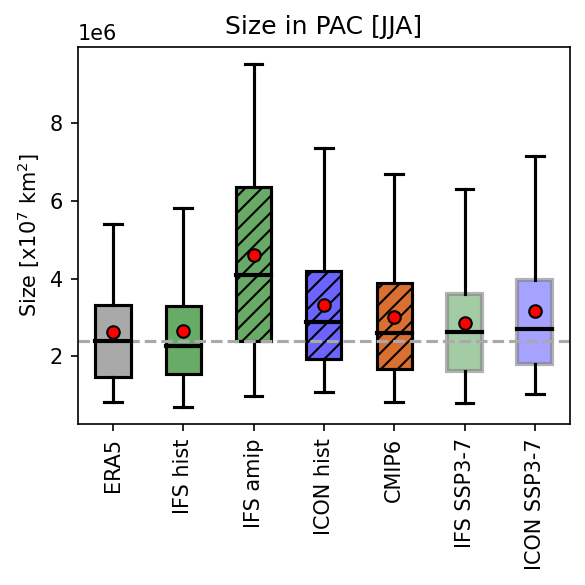

In [52]:
# Organize into a dictionary
data_dic = {
    'ERA5': era5_df['Size'].values,
    'IFS hist': ifs_his['Size'].values,
    'IFS amip': ifs_amip['Size'].values,
    'ICON hist': icon_his['Size'].values,
    'CMIP6': cmip_dfs['Size'].values,
    'IFS SSP3-7': ifs_fut['Size'].values,
    'ICON SSP3-7': icon_fut['Size'].values,
}

### Signifance
reference = 'ERA5'

# Storage for results
results = {
    'Simulation': [],
    'p-value (Mann-Whitney)': [],
    'KL divergence (sim || ERA5)': []
}

# Common bins for histograms
max_val = max([np.max(vals) for vals in data_dic.values()])
bins = np.linspace(0, max_val + 5, 20)

# Compute
for label, values in data_dic.items():
    if label == reference:
        continue

    stat, p_value = mannwhitneyu(values, data_dic[reference], alternative='two-sided')
    hist_model, _ = np.histogram(values, bins=bins, density=True)
    hist_ref, _ = np.histogram(data_dic[reference], bins=bins, density=True)

    hist_model = np.where(hist_model == 0, 1e-8, hist_model)
    hist_ref = np.where(hist_ref == 0, 1e-8, hist_ref)

    kl_div = entropy(hist_model, hist_ref)

    results['Simulation'].append(label)
    results['p-value (Mann-Whitney)'].append(p_value)
    results['KL divergence (sim || ERA5)'].append(kl_div)

# Build DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Map labels to p-values
pval_map = dict(zip(results_df['Simulation'], results_df['p-value (Mann-Whitney)']))

p_values = []
for label in labels:
    if label == 'ERA5':
        p_values.append(np.nan)
    else:
        p_values.append(pval_map.get(label, np.nan))


fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True, showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Rotate x-axis labels 
plt.xticks(rotation=90)

# Color + hatches based on significance
#for patch, color, pval in zip(bplot['boxes'], colors, p_values):
#    patch.set_facecolor(color)
#    if not np.isnan(pval) and pval < 0.05:
#        patch.set_hatch('///')  # Hatching for significant
#        patch.set_edgecolor('black')
#    else:
#        patch.set_alpha(0.7)  # Transparency for non-significant
# Define which labels are future scenarios (for styling)
future_labels = ['IFS SSP3-7', 'ICON SSP3-7']

for patch, label, color, pval in zip(bplot['boxes'], labels, colors, p_values):
    patch.set_facecolor(color)
    
    if label in future_labels:
        # Style SSP3-7.0 boxes differently
        patch.set_edgecolor('gray')
        patch.set_linewidth(2)
        patch.set_alpha(0.6)  # faded appearance
    else:
        # Historical/AMIP: apply significance hatching if needed
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
        if not np.isnan(pval) and pval < 0.05:
            patch.set_hatch('///')

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_df['Size'])
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Mean ({mean_era5:.2f})')


ax.set_ylabel('Size [x10$^7$ km$^2$]')
ax.set_title('Size in '+domain+' ['+sufix+']')

plt.tight_layout()
plt.savefig('km-scale_size-blocks_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [53]:
### CLIMATE CHANGE create new plots?

## Plotting ABS metric

In [54]:
###
### Compute mean frequency
sufix='JJA' ### YEAR, DJF, JJA
## Hemisphere
hemisphere='NH' ### NH, SH
## Variable 
var='IB' #'Blocking' #'IB'

### Open saved data IFS historical
inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ABS_Z500/'

#block_ifs = xr.open_dataset(inpath+'blocking.nc') ### Blocks
block_ifs = xr.open_dataset(inpath+'/IB.nc')    ###Instantanueos
ifs_z500_day= block_ifs.sel(time=slice('1990','2019'))


###=== IFS hirtorical
if sufix =='YEAR':
    blocks_ifs_his=ifs_z500_day
if sufix =='DJF':
    blocks_ifs_his=ifs_z500_day.sel(time=ifs_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_his=ifs_z500_day.sel(time=ifs_z500_day.time.dt.month.isin([6, 7, 8]))

acc_ifs_his = blocks_ifs_his[var].mean(dim='time')*100 ##Instatneus


###open ERA5
inpath='/work/bm1235/b382006/era5/block/ABS_Z500/'
#block_era5 = xr.open_mfdataset(inpath+'BLOCKS-era5_1990-2020.nc') ## Blocks
block_era5 = xr.open_mfdataset(inpath+'IB_BLOCKS-era5_1990-2020.nc') ## Instatanueos
era5_z500_day= block_era5.sel(time=slice('1990','2019'))

if sufix =='YEAR':
    blocks_era5=era5_z500_day
if sufix =='DJF':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_era5=era5_z500_day.sel(time=era5_z500_day.time.dt.month.isin([6, 7, 8]))
    
### accumulate 
acc_era5=blocks_era5[var].mean(dim='time')*100 ## Instatanoues

acc_era5=acc_era5.rename({'latitude':'lat'})
acc_era5=acc_era5.rename({'longitude':'lon'})

#print(acc_ifs_his)
#print(acc_era5)

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [55]:
'''
def preprocess(ds):
    return ds.sortby('time')
    
###=== Save CMIP6 frequencies 
case='IB' #block_ABS-Z500, ExtendB, IB
var='IB'

# 'ACCESS-CM2', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MIROC6','MRI-ESM2-0'
model='MRI-ESM2-0'
ens='r1i1p1f1' #'r1i1p1f1', 'r11i1p1f1'
#inpath='/work/bm1235/b382006/cmip6/historical/'+model+'/'+ens+'/block/ABS_500/'
inpath='/scratch/b/b382006/cmip6/historical/'+model+'/'+ens+'/block/ABS_500/'
outpath='/scratch/b/b382006/cmip6/historical/'+model+'/'+ens+'/block/ABS_500/'


print(inpath+case+"_*.nc")
### open file
cmip6_z500=xr.open_mfdataset(inpath+case+"_*.nc",combine='by_coords')
cmip6_z500_day= cmip6_z500.sel(time=slice('1990','2019'))

for sufix in ['YEAR', 'DJF', 'JJA']:
    print(sufix)
### select period
    if sufix =='YEAR':
        blocks_cmip6 = cmip6_z500_day 
    if sufix =='DJF':
        blocks_cmip6 = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([1, 2, 12]))
    if sufix =='JJA':
        blocks_cmip6 = cmip6_z500_day.sel(time=cmip6_z500_day.time.dt.month.isin([6, 7, 8]))

### accumulate 
    acc_cmip6 = blocks_cmip6[var].mean(dim='time')*100

###Save season as netcdf CMIP6
    if sufix =='YEAR':
        acc_cmip6.to_netcdf(outpath+'Feq_'+case+'-cmip6_'+sufix+'.nc')
    if sufix =='DJF':
        acc_cmip6.to_netcdf(outpath+'Feq_'+case+'-cmip6_'+sufix+'.nc')
    if sufix =='JJA':
        acc_cmip6.to_netcdf(outpath+'Feq_'+case+'-cmip6_'+sufix+'.nc')

print('done')
'''

'\ndef preprocess(ds):\n    return ds.sortby(\'time\')\n    \n###=== Save CMIP6 frequencies \ncase=\'IB\' #block_ABS-Z500, ExtendB, IB\nvar=\'IB\'\n\n# \'ACCESS-CM2\', \'CESM2\', \'CESM2-WACCM\', \'EC-Earth3\', \'MPI-ESM1-2-HR\', \'MPI-ESM1-2-LR\', \'MIROC6\',\'MRI-ESM2-0\'\nmodel=\'MRI-ESM2-0\'\nens=\'r1i1p1f1\' #\'r1i1p1f1\', \'r11i1p1f1\'\n#inpath=\'/work/bm1235/b382006/cmip6/historical/\'+model+\'/\'+ens+\'/block/ABS_500/\'\ninpath=\'/scratch/b/b382006/cmip6/historical/\'+model+\'/\'+ens+\'/block/ABS_500/\'\noutpath=\'/scratch/b/b382006/cmip6/historical/\'+model+\'/\'+ens+\'/block/ABS_500/\'\n\n\nprint(inpath+case+"_*.nc")\n### open file\ncmip6_z500=xr.open_mfdataset(inpath+case+"_*.nc",combine=\'by_coords\')\ncmip6_z500_day= cmip6_z500.sel(time=slice(\'1990\',\'2019\'))\n\nfor sufix in [\'YEAR\', \'DJF\', \'JJA\']:\n    print(sufix)\n### select period\n    if sufix ==\'YEAR\':\n        blocks_cmip6 = cmip6_z500_day \n    if sufix ==\'DJF\':\n        blocks_cmip6 = cmip6_z500_day.s

In [56]:
### Open cmip6 models '/scratch/b/b382006/cmip6/historical/'+model+'/'+ens+'/block/ANO_Z500/'
### dictonary with models
models=[
    'MRI-ESM2-0',
    'ACCESS-CM2',
    'EC-Earth3',    
    'MPI-ESM1-2-HR',
    'CESM2-WACCM', 
    'MIROC6',
    'MPI-ESM1-2-LR',
    'CESM2'
    ]

var='IB' # 'Blocking', 'IB'
case='IB' # 'BLOCKS', 'IB'
query = dict(
    source_id=models,  #Only choosing one model here
    member_id=['r10i1p1f1', 
               'r1i1p1f1', 
               'r2i1p1f1', 
               'r3i1p1f1', 
               'r4i1p1f1', 
               'r5i1p1f1', 
               'r6i1p1f1', 
               'r7i1p1f1', 
               'r8i1p1f1', 
               'r9i1p1f1',
               'r11i1p1f1']
    )
block_cmip6=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    if sid=='CESM2':
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/historical/'+sid+'/'+query['member_id'][10]+'/block/ABS_500/Feq_'+case+'-cmip6_'+sufix+'.nc').load()
    else:
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/historical/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_'+case+'-cmip6_'+sufix+'.nc').load()

    block_cmip6.append(tmp[var] )
    print(sid,'/scratch/b/b382006/cmip6/historical/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_'+case+'-cmip6_'+sufix+'.nc')

#concatening
block_cmip6_ens=xr.concat(block_cmip6, "model")

### mean value
block_cmip6=block_cmip6_ens.mean(axis=0)

MRI-ESM2-0 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
ACCESS-CM2 /scratch/b/b382006/cmip6/historical/ACCESS-CM2/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
EC-Earth3 /scratch/b/b382006/cmip6/historical/EC-Earth3/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
MPI-ESM1-2-HR /scratch/b/b382006/cmip6/historical/MPI-ESM1-2-HR/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
CESM2-WACCM /scratch/b/b382006/cmip6/historical/CESM2-WACCM/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
MIROC6 /scratch/b/b382006/cmip6/historical/MIROC6/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
MPI-ESM1-2-LR /scratch/b/b382006/cmip6/historical/MPI-ESM1-2-LR/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc
CESM2 /scratch/b/b382006/cmip6/historical/CESM2/r1i1p1f1/block/ABS_500/Feq_IB-cmip6_JJA.nc


In [57]:
### compute difference
ifs_his_bias=acc_ifs_his-acc_era5
ifs_his_bias_rel = (acc_ifs_his-acc_era5)/acc_era5*1e2

bias_block_ens = block_cmip6_ens - acc_era5
bias_block_ens_rel = (block_cmip6_ens - acc_era5) /  acc_era5*1e2
bias_cmip6 = bias_block_ens.mean(axis=0)
bias_cmip6_rel = (block_cmip6-acc_era5)/acc_era5*1e2

### Model difference IFS - CMIP6
sims_diff=  acc_ifs_his - block_cmip6
sims_diff_rel=  (acc_ifs_his - block_cmip6)/block_cmip6*1e2


### Filtering anf filling longitude
acc_era5_fil = gaussian_filter(acc_era5, sigma=1)
cacc_era5, clon = cutil.add_cyclic(acc_era5_fil, acc_era5.lon)
#acc_era5

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encou

In [58]:
### RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())
'''
# Ensure proper slicing order for latitude
era5_lat_slice = acc_era5.sel(lat=slice(0, 90))

# Calculate RMSE for all ensemble members
rmse_cmip6_values = [
    rmse(block_cmip6_ens[i, ...].sel(lat=slice(0, 90)), era5_lat_slice)
    for i in range(8)
]

# Calculate the average RMSE
rmse_cmip6 = np.mean(rmse_cmip6_values)

rmse_ifs=rmse(acc_ifs_his.sel(lat=slice(0,90)), era5_lat_slice))
#print('IFS: ', rmse_ifs, 'CMIP6: ', rmse_cmip6)
'''
#bias_ifs.plot() ### -7, 7
#acc_era5.plot() ### 0, 16

"\n# Ensure proper slicing order for latitude\nera5_lat_slice = acc_era5.sel(lat=slice(0, 90))\n\n# Calculate RMSE for all ensemble members\nrmse_cmip6_values = [\n    rmse(block_cmip6_ens[i, ...].sel(lat=slice(0, 90)), era5_lat_slice)\n    for i in range(8)\n]\n\n# Calculate the average RMSE\nrmse_cmip6 = np.mean(rmse_cmip6_values)\n\nrmse_ifs=rmse(acc_ifs_his.sel(lat=slice(0,90)), era5_lat_slice))\n#print('IFS: ', rmse_ifs, 'CMIP6: ', rmse_cmip6)\n"

In [59]:
## Plotting IFS vs CMIP6
'''
### Hemisphere selection
#hemisphere = 'NH'  # 'NH' or 'SH'

### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12]
contour_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
'''
if sufix == 'DJF':
    main_levels = [1, 2, 3, 4, 5]
    contour_levels = [-3,-2.5,-2,-1.5,-0.5,0.5,1.5,2,2.5,3]
if sufix == 'JJA':
    main_levels = [ 1, 2, 4, 6]
    contour_levels = [-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]
'''
hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=300, subplot_kw={'projection': proj})

### Define data and titles
data_list = [
    (bias_ifs, bias_ifs_rel,cpt_convert, 'b) IFS hist', 'both'),
    (bias_cmip6,bias_cmip6_rel, cpt_convert, 'c) CMIP6 (x8)', 'both'),
    (sims_diff,sims_diff_rel, cpt_convert, 'd) IFS hist - CMIP6', 'both')
]

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

plot=None
### Loop through subplots
for ax, (data,rel, cmap, title, extend_mode) in zip(axes.flatten(), data_list):

    plot = data.plot(ax=ax, levels=contour_levels, 
                     cmap=cmap, extend=extend_mode, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add contour lines using ERA5 as reference
    contour=ax.contour(clon, acc_era5.lat, cacc_era5, levels=main_levels, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(contour, fontsize=6, inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')

    # Add land features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)

    # Apply circular boundary
    ax.set_boundary(circle, transform=ax.transAxes)

    # Set title
    ax.set_title(title, fontsize=9)

### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

### Save figure
#plt.savefig(f'IFS_ABS_block_bias_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)
'''

'\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstack([np.sin(theta), np.cos(theta)]).T\ncircle = mpath.Path(verts * radius + center)\n\n### Define figure and axes\nfig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=300, subplot_kw={\'projection\': proj})\n\n### Define data and titles\ndata_list = [\n    (bias_ifs, bias_ifs_rel,cpt_convert, \'b) IFS hist\', \'both\'),\n    (bias_cmip6,bias_cmip6_rel, cpt_convert, \'c) CMIP6 (x8)\', \'both\'),\n    (sims_diff,sims_diff_rel, cpt_convert, \'d) IFS hist - CMIP6\', \'both\')\n]\n\n### Common colorb

In [60]:
## Plot each cmip6 separately
'''
### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12]
contour_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
'''
if sufix == 'DJF':
    main_levels = [1, 2, 3, 4, 5]
    contour_levels = [-3,-2.5,-2,-1.5,-0.5,0.5,1.5,2,2.5,3]
if sufix == 'JJA':
    main_levels = [ 1, 2, 4, 6]
    contour_levels = [-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]
'''
### Hemisphere selection
#hemisphere = 'SH'  # 'NH' or 'SH'

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(3, 3, figsize=(8, 8), dpi=100, subplot_kw={'projection': proj})


### Define data and titles
### bias_block_ens
data_list = [bias_block_ens[0,...], bias_block_ens[1,...],bias_block_ens[2,...], 
             bias_block_ens[3,...], bias_block_ens[4,...],bias_block_ens[5,...],
             bias_block_ens[6,...], bias_block_ens[7,...]]
data_rel = [bias_block_ens_rel[0,...], bias_block_ens_rel[1,...], bias_block_ens_rel[2,...],
            bias_block_ens_rel[3,...], bias_block_ens_rel[4,...], bias_block_ens_rel[5,...],
            bias_block_ens_rel[6,...], bias_block_ens_rel[7,...]]

titles=models
cmaps = [cpt_convert, cpt_convert,cpt_convert,cpt_convert, cpt_convert,cpt_convert, cpt_convert,cpt_convert]
extend_modes = ['both', 'both', 'both','both', 'both', 'both', 'both', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

### Initialize plot variable for colorbar
plot = None
### Loop through subplots
for ax, data, rel, title, cmap, extend in zip(axes.flatten(), data_list, data_rel, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels= contour_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Add contour lines using ERA5 as reference
    contour=ax.contour(clon, acc_era5.lat, cacc_era5, levels=main_levels, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(contour, fontsize=6, inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)


### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)
'''

'\n### Hemisphere selection\n#hemisphere = \'SH\'  # \'NH\' or \'SH\'\n\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstack([np.sin(theta), np.cos(theta)]).T\ncircle = mpath.Path(verts * radius + center)\n\n### Define figure and axes\nfig, axes = plt.subplots(3, 3, figsize=(8, 8), dpi=100, subplot_kw={\'projection\': proj})\n\n\n### Define data and titles\n### bias_block_ens\ndata_list = [bias_block_ens[0,...], bias_block_ens[1,...],bias_block_ens[2,...], \n             bias_block_ens[3,...], bias_block_ens[4,...],bias_block_ens[5,...],\n     

### Climate change

In [61]:
### Open saved data IFS fut
var='IB' # IB, Blocking
inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'
#block_ifs = xr.open_dataset(inpath+'blocking.nc')
block_ifs = xr.open_dataset(inpath+'IB.nc')
ifs_z500_day_fut= block_ifs.sel(time=slice('2020','2049'))

###=== 
if sufix =='YEAR':
    blocks_ifs_fut=ifs_z500_day_fut
if sufix =='DJF':
    blocks_ifs_fut=ifs_z500_day_fut.sel(time=ifs_z500_day_fut.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_fut=ifs_z500_day_fut.sel(time=ifs_z500_day_fut.time.dt.month.isin([6, 7, 8]))

acc_ifs_fut = blocks_ifs_fut[var].mean(dim='time')*100

### open IFS EERIE AMIP file
inpath='/scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/ABS_Z500/'
#ifs_z500_day_amip=xr.open_dataset(inpath+"blocking.nc")
ifs_z500_day_amip=xr.open_dataset(inpath+"IB.nc")
###=== 
if sufix =='YEAR':
    blocks_ifs_amip=ifs_z500_day_amip
if sufix =='DJF':
    blocks_ifs_amip=ifs_z500_day_amip.sel(time=ifs_z500_day_amip.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_ifs_amip=ifs_z500_day_amip.sel(time=ifs_z500_day_amip.time.dt.month.isin([6, 7, 8]))

acc_ifs_amip = blocks_ifs_amip[var].mean(dim='time')*100


######ICON production
inpath='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'
#icon_z500_day_fut=xr.open_dataset(inpath+"blocking.nc")
icon_z500_day_fut=xr.open_dataset(inpath+"IB.nc")
icon_z500_day_fut = icon_z500_day_fut.assign_coords(lon=((icon_z500_day_fut.lon + 180) % 360 - 180)).sortby("lon")
icon_z500_day_fut= icon_z500_day_fut.sel(time=slice('2020','2049'))

#### ICON
if sufix =='YEAR':
    blocks_icon_fut=icon_z500_day_fut
if sufix =='DJF':
    blocks_icon_fut=icon_z500_day_fut.sel(time=icon_z500_day_fut.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_icon_fut=icon_z500_day_fut.sel(time=icon_z500_day_fut.time.dt.month.isin([6, 7, 8]))

### accumulate ICON
acc_icon_fut = blocks_icon_fut[var].mean(dim='time')*100

###ICON production DestinE
inpath='/scratch/b/b382006/icon-climate-dt/block/ABS_Z500/'
#icon_z500_day_his=xr.open_dataset(inpath+"blocking.nc")
icon_z500_day_his=xr.open_dataset(inpath+"IB.nc")
### change longitude to -179 to 180
icon_z500_day_his = icon_z500_day_his.assign_coords(lon=((icon_z500_day_his.lon + 180) % 360 - 180)).sortby("lon")

#### ICON
if sufix =='YEAR':
    blocks_icon_his=icon_z500_day_his
if sufix =='DJF':
    blocks_icon_his=icon_z500_day_his.sel(time=icon_z500_day_his.time.dt.month.isin([1, 2, 12]))
if sufix =='JJA':
    blocks_icon_his=icon_z500_day_his.sel(time=icon_z500_day_his.time.dt.month.isin([6, 7, 8]))

### accumulate ICON
acc_icon_his = blocks_icon_his[var].mean(dim='time')*100
acc_icon_his_nan = acc_icon_his.where(acc_icon_his < 20) ### temporal correction, wating for DestinE to fix interpolation
acc_icon_his=acc_icon_his_nan

### nextGEMS biases
icon_fut_bias=  acc_icon_fut - acc_era5
ifs_fut_bias=  acc_ifs_fut - acc_era5
### eerie biases
ifs_amip_bias = acc_ifs_amip - acc_era5
### DestinE
icon_his_bias = acc_icon_his - acc_era5

### km scale ensemble
icon_interp = icon_his_bias.interp(lon=ifs_his_bias.lon) # Interpolate ICON to IFS grid
kms_bias = (ifs_his_bias + icon_interp)/2

############# difference RELATIVE
### nextGEMS biases
icon_fut_bias_rel =  (acc_icon_fut - acc_era5)/acc_era5*1e2
ifs_fut_bias_rel=  (acc_ifs_fut - acc_era5)/acc_era5*1e2
### eerie biases
ifs_amip_bias_rel = (acc_ifs_amip - acc_era5)/acc_era5*1e2
### DestinE
icon_his_bias_rel = (acc_icon_his - acc_era5)/acc_era5*1e2

### km-scale ensemble mean biases
icon_interp = icon_his_bias_rel.interp(lon=ifs_his_bias_rel.lon) # Interpolate ICON to IFS grid
kms_bias_rel = (ifs_his_bias_rel + icon_interp)/2

############## difference absolute
ifs_chgs=  acc_ifs_fut - acc_ifs_his
ifs_chgs_rel=  (acc_ifs_fut - acc_ifs_his)/acc_ifs_his*1e2

icon_chgs=  acc_icon_fut - acc_icon_his
icon_chgs_rel=  (acc_icon_fut - acc_icon_his)/acc_icon_his*1e2

In [62]:
### Plot only IFS changes

In [63]:
'''
### Hemisphere selection
hemisphere = 'NH'  # 'NH' or 'SH'

### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12]
contour_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]

if sufix == 'DJF':
    main_levels = [1, 2, 3, 4, 5]
    contour_levels = [-3,-2.5,-2,-1.5,-0.5,0.5,1.5,2,2.5,3]
if sufix == 'JJA':
    main_levels = [ 1, 2, 4, 6]
    contour_levels = [-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]


hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(1, 3, figsize=(8, 8), dpi=150, subplot_kw={'projection': proj})

### Define data and titles
data_list = [acc_ifs_his,acc_ifs_fut, ifs_chgs]
titles = ['a) Historical','b) SSP3-7', 'c) Changes']
cmaps = ['Oranges','Oranges', cpt_convert]
extend_modes = ['max','max', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

### Loop through subplots
for ax, data, title, cmap, extend in zip(axes.flatten(), data_list, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels=contour_levels if title == 'c) Changes' else main_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using IFS historical as a reference
    contour = acc_ifs_his.plot.contour(ax=ax, colors='k', linewidths=0.8, levels=main_levels, transform=ccrs.PlateCarree())
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)

### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

### Save figure
'''

'\n### Hemisphere selection\nhemisphere = \'NH\'  # \'NH\' or \'SH\'\n\n### Define contour levels\nmain_levels = [2, 4, 6, 8, 10, 12]\ncontour_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]\n\nif sufix == \'DJF\':\n    main_levels = [1, 2, 3, 4, 5]\n    contour_levels = [-3,-2.5,-2,-1.5,-0.5,0.5,1.5,2,2.5,3]\nif sufix == \'JJA\':\n    main_levels = [ 1, 2, 4, 6]\n    contour_levels = [-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]\n\n\nhemisphere_settings = {\n    \'NH\': {\'projection\': ccrs.NorthPolarStereo(), \'latS\': 35, \'latN\': 90},\n    \'SH\': {\'projection\': ccrs.SouthPolarStereo(), \'latS\': -35, \'latN\': -90}\n}\n\nproj = hemisphere_settings[hemisphere][\'projection\']\nlonW, lonE = -180, 180\nlatS, latN = hemisphere_settings[hemisphere][\'latS\'], hemisphere_settings[hemisphere][\'latN\']\n\n### Define circular boundary\ntheta = np.linspace(0, 2 * np.pi, 100)\ncenter, radius = [0.5, 0.5], 0.5\nverts = np.vstack([np.sin(theta), np.cos(theta)]).T\ncircle = mpath.Path(verts * radius + cente

In [64]:
### Use ERA5 as a reference and include ICON
icon_his_bias

<xarray.DataArray 'IB' (lat: 181, lon: 360)>
dask.array<subtract, shape=(181, 360), dtype=float64, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

In [65]:
#kms_bias.plot()

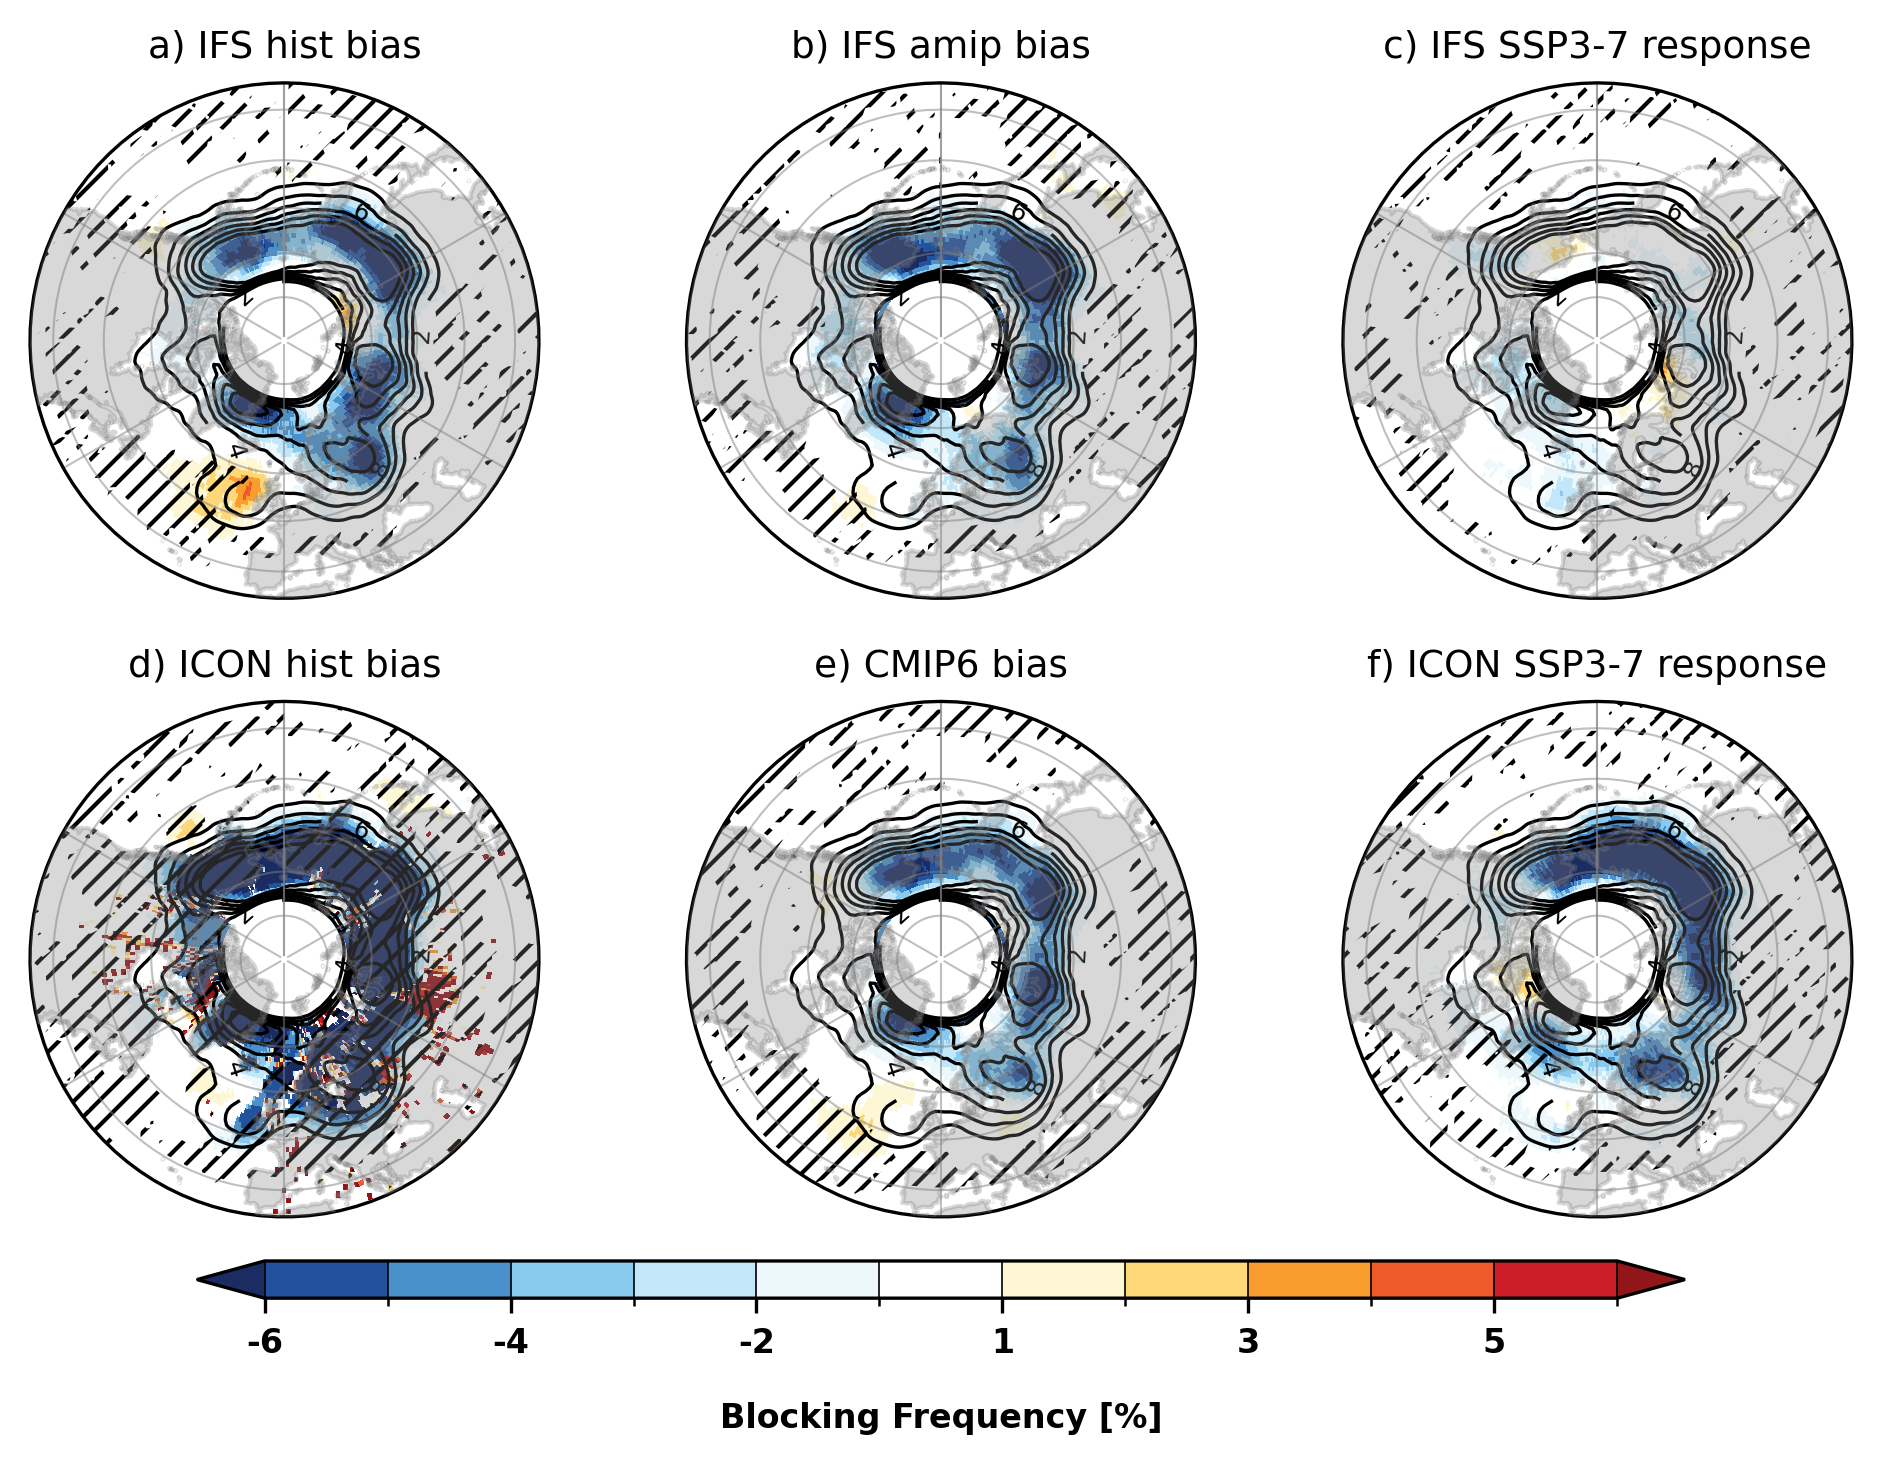

In [66]:
### Hemisphere selection
#hemisphere = 'NH'  # 'NH' or 'SH'

### Define contour levels
main_levels = [2, 4, 6, 8, 10, 12]
contour_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]

'''
if sufix == 'DJF':
    main_levels = [1, 2, 3, 4, 5]
    contour_levels = [-3,-2.5,-2,-1.5,-0.5,0.5,1.5,2,2.5,3]
#    main_levels = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3,4]
#    contour_levels = [-0.8,-0.6,-0.4,-0.2,-0.1,-0.05, 0.05,0.1,0.2,0.4,0.6,0.8]

if sufix == 'JJA':
    main_levels = [ 1, 2, 4, 6]
    contour_levels = [-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]
'''

hemisphere_settings = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'latS': 35, 'latN': 90},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'latS': -35, 'latN': -90}
}

proj = hemisphere_settings[hemisphere]['projection']
lonW, lonE = -180, 180
latS, latN = hemisphere_settings[hemisphere]['latS'], hemisphere_settings[hemisphere]['latN']

### Define circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Define figure and axes
fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=300, subplot_kw={'projection': proj})
#fig, axes = plt.subplots(3, 3, figsize=(6, 8), dpi=300, subplot_kw={'projection': proj})

### Define data and titles acc_icon_fut, acc_era5 [Look at ICON!!!!!!!!!!!!!!!!!!!!!!!!]
data_list = [ifs_his_bias, ifs_amip_bias, ifs_chgs, icon_his_bias, bias_cmip6,icon_fut_bias]
data_rel = [ifs_his_bias_rel, ifs_amip_bias_rel, ifs_chgs_rel, icon_his_bias_rel, bias_cmip6_rel,icon_fut_bias_rel]
titles = ['a) IFS hist bias','b) IFS amip bias', 'c) IFS SSP3-7 response', 'd) ICON hist bias', 'e) CMIP6 bias','f) ICON SSP3-7 response']
cmaps = [ cpt_convert,cpt_convert, cpt_convert, cpt_convert, cpt_convert, cpt_convert]
extend_modes = ['both', 'both','both', 'both', 'both', 'both']

#data_list = [ifs_his_bias, ifs_amip_bias, ifs_chgs, icon_his_bias,bias_cmip6,icon_chgs,kms_bias]
#data_rel = [ifs_his_bias_rel, ifs_amip_bias_rel, ifs_chgs_rel, icon_his_bias_rel, bias_cmip6_rel,icon_chgs_rel,kms_bias_rel]
#titles = ['a) IFS hist bias','b) IFS amip bias', 'c) IFS SSP3-7 response', 'd) ICON hist bias', 'e) CMIP6 bias', 'f) ICON SSP3-7 response','g)IFS + ICON hist bias']
#cmaps = [ cpt_convert,cpt_convert, cpt_convert, cpt_convert, cpt_convert, cpt_convert, cpt_convert]
#extend_modes = ['both', 'both','both', 'both', 'both', 'both', 'both']

### Common colorbar settings
cbar_kwargs = {
    'label': 'Blocking Frequency [%]',
    'orientation': 'horizontal',
    'pad': 0.05,
    'shrink': 0.8,
    'aspect': 40
}

plot=None
### Loop through subplots
for ax, data, rel, title, cmap, extend in zip(axes.flatten(), data_list, data_rel, titles, cmaps, extend_modes):
    plot = data.plot(ax=ax, levels= contour_levels, 
                     cmap=cmap, extend=extend, transform=ccrs.PlateCarree(), add_colorbar=False)
    
    # Contours using ERA5 as a reference
    contour = ax.contour(clon, acc_era5.lat, cacc_era5, colors='k', linewidths=0.8, 
                                    levels=main_levels, transform=ccrs.PlateCarree())    
    ax.clabel(contour, fontsize=6, inline=True, inline_spacing=-2)

    density=4
    ax.contourf(
        rel.lon, rel.lat, abs(rel)>80,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'],
        )
    
    
    # Set map extent and gridlines
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    
    # Add features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Set title
    ax.set_title(title, fontsize=9)
    
# Hide unused axes
for ax in axes.flatten()[len(data_list):]:
    ax.set_visible(False)
    
### Add a common colorbar at the bottom
cbar = fig.colorbar(plot, ax=axes, orientation='horizontal', pad=0.2, aspect=40, shrink=0.8,drawedges=True)
cbar.ax.set_xticklabels(contour_levels, fontsize=8, weight="bold")
cbar.set_label('Blocking Frequency [%]', size=8, fontweight="bold", labelpad=10)


### Adjust layout
plt.subplots_adjust(bottom=0.25)

### Save figure
plt.savefig(f'km-scale_ABS_block_bias_{sufix}_{hemisphere}.jpg', dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [67]:
###
#acc_icon_his

In [68]:
#acc_icon_his_nan = acc_icon_his.where(acc_icon_his < 20)
#acc_icon_his_nan.plot(vmin=0, vmax=25, cmap='viridis')

## Plot a case

In [ ]:
#########
import intake
import healpy as hp
import cartopy.feature as cf

def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=Nested, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)
    
def worldmap(var,cbar,clabel = None, ctitle = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if ctitle== None: # Set the label for the colorbar
         ax.set_title(" ")
    else:
         ax.set_title(ctitle)     
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label(" ")
        else:
            cbar.set_label(clabel)
            
def plot_healpix(data_healpix,
                 proj = 'mercator]',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 clabel = None,
                 ctitle = None,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None,
                closefile=False):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    if (savefig == True) and (os.path.exists(savepath)):
        return
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,clabel=clabel,ctitle=ctitle,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(14, 10), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            
            if ctitle== None: # Set the label for the colorbar
                    ax.set_title(" ")
            else:
                    ax.set_title(ctitle)  
            
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                if clabel== None: # Set the label for the colorbar
                    cbar.set_label(" ")
                else:
                    cbar.set_label(clabel)  
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=clabel,nest=Nested)
    if savefig == True:
        plt.savefig(savepath,dpi = 500, format = 'jpg')
    plt.show()
    if closefile == True:
        plt.close()
        

In [ ]:
### Find bid (flag of most intense blockings) 
#### Select domain and period
domain='ATL' ### PAC, ATL, NH
sufix='JJA' ### YEAR, DJF, JJA


###Load blockings
block_ano = xr.open_dataset('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.nc')
#ano = xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/_*.nc')

###2021
block_df =  pd.read_csv('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ANO_Z500_90th/BLOCKS-ifs-production-2020-2049.csv', delimiter=',',header=0)
block_df['year']=block_df.Date.str[:4]
block_df['month']=block_df.Date.str[4:6]
block_values = block_df.groupby('Flag').size().reset_index(name='Duration')
block_df = block_df.merge(block_values, on='Flag', how='left')

### filter domain
if domain == 'NH':
    block_reg = block_df[(block_df['Latitude'] > 0 )]
if domain == 'ATL':
    block_reg = block_df[(block_df['Latitude'] > 0 ) & (block_df['Longitude'] > -90 ) & (block_df['Longitude'] < 90 )]
if domain == 'PAC':
    block_reg = block_df[(block_df['Latitude'] > 0 ) & ((block_df['Longitude'] > 90 ) | (block_df['Longitude'] < -90 ))]

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")

block_seas = block_reg[block_reg['month'].isin(months)]

In [ ]:
### keep only unique flags
block_values = block_seas.drop_duplicates(subset=['Flag']).reset_index(drop=True)
### save the 10 long lasting blocks
long_block=block_values.loc[block_values['Duration'].nlargest(10).index]
print(long_block)

n=7 ### which of one of the longest [0,6]
timb=long_block['Date'].iloc[n]
bid= long_block['Flag'].iloc[n]

lonts = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
latts = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])
dates = np.asarray(block_df['Date'].iloc[np.where(block_df['Flag']==bid)]) #'20210326_12'

### for one example
dates=dates[0:17]
lonts = lonts[0:17]
latts = latts[0:17]

start=dates[0][0:4]+'-'+dates[0][4:6]+'-'+dates[0][6:8]
end=dates[-1][0:4]+'-'+dates[-1][4:6]+'-'+dates[-1][6:8]
print(start,end, latts, lonts)

In [ ]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [ ]:
# which IFS experiments are available?
#print(list(cat.IFS))
### select simulation / prefix
#ifs_run='IFS_9-FESOM_5-production'
#print(list(cat.IFS[ifs_run]))

###Load more data
lon = np.linspace(-179, 180, 360)
lat = np.linspace(-90, 90, 181)
lon2, lat2 = np.meshgrid(lon, lat)

data = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512_2020'].to_dask()
#data = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2040s'].to_dask()
data

In [ ]:
#######
data['pv'].sel(time=start+'T00',level=500)
pv_sample

In [ ]:
#pv_sample = data['pv'].sel(time=start,level=500).resample(time='D').mean()
# Are we using Nested Healpix or Ring? 
#Nested=True
pv_sample = data['pv'].sel(time=start+'T00',level=500) * 1000000
#plot_healpix(pv_sample, proj = 'np',cbar=True, clabel='pvu' , ctitle='2024-01', cmap='RdYlBu_r', savefig=False, vmin=-3, vmax=3)
###
projection = ccrs.Robinson(central_longitude=10)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-40, -80, 30, 80], crs=ccrs.PlateCarree())

egh.healpix_show(pv_sample, ax=ax, cmap=cmocean.cm.thermal, vmin=-3, vmax=3)
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

In [41]:
###

In [ ]:
timb=start+'T00'
data_example = data['tp'].sel(time=timb)

pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=lon2, phi=lat2, nest=True, lonlat=True
    )
data_example

In [101]:
var='tp'
sample = np.reshape(data_example.values[pix],newshape=(1,len(lat),len(lon)))
    
        # create DataArray with proper name, dimensions, and coordinates
da = xr.DataArray(
            data=sample,
            name=var,
            dims=["time","lat", "lon"],
            coords=dict(
                lon=lon,
                lat=lat,
                time=np.atleast_1d(data['time'].sel(time=timb))
            ),
            attrs=dict(
            data[var].attrs,
            ),
            )

In [102]:
#data_example = data['tp'].sel(time=timb)

In [103]:
var='msl'
data_example = data['msl'].sel(time=timb)

sample = np.reshape(data_example.values[pix],newshape=(1,len(lat),len(lon)))
    
        # create DataArray with proper name, dimensions, and coordinates
msl = xr.DataArray(
            data=sample,
            name=var,
            dims=["time","lat", "lon"],
            coords=dict(
                lon=lon,
                lat=lat,
                time=np.atleast_1d(data['time'].sel(time=timb))
            ),
            attrs=dict(
            data[var].attrs,
            ),
            )
#da.isel(time=0).plot()
#da*1000

In [104]:
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil


#ano_new, clon = cutil.add_cyclic(ano['z'].sel(time=timb), ano.lon)

block_new, clon= cutil.add_cyclic(block_ano['flag'].sel(time=timb), block_ano.lon)

In [105]:
timb[:14]
clonts=lonts[0:26]
clatts=latts[0:26] 
dates[0:24]

array(['20431223_00', '20431224_00', '20431225_00', '20431226_00',
       '20431227_00', '20431228_00', '20431229_00', '20431230_00',
       '20431231_00', '20440101_00', '20440102_00'], dtype=object)

<Figure size 2100x900 with 0 Axes>

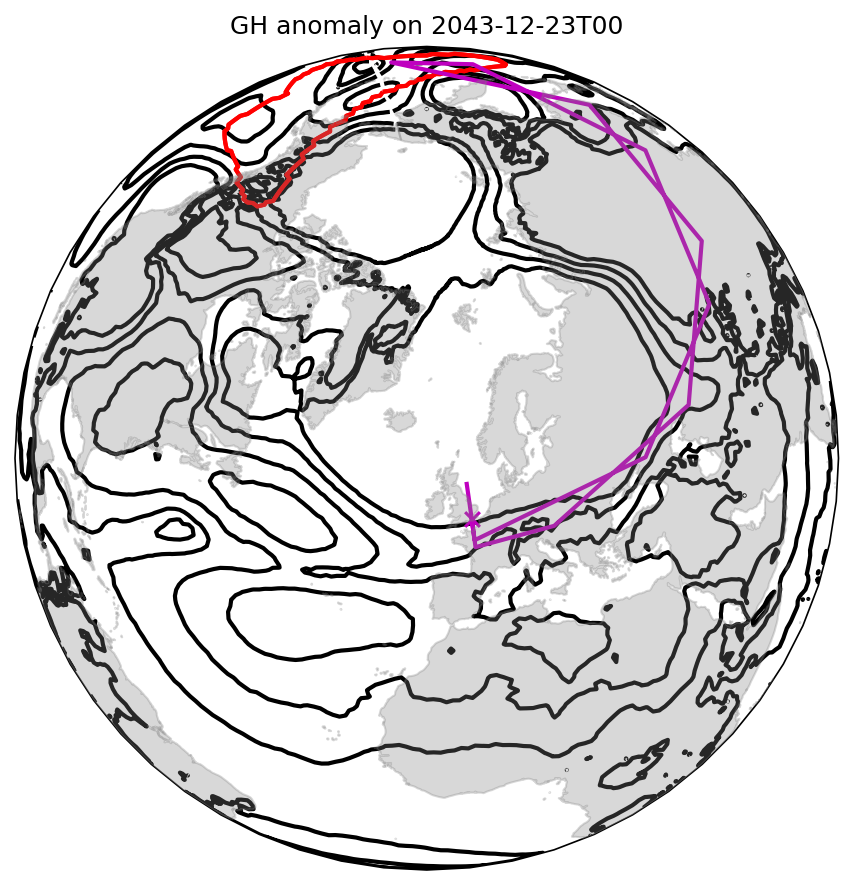

In [107]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath

plt.figure(figsize=(14,6),dpi=150)
#fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
lon_0 = -10 #-185
lat_0 =  60.0
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150, subplot_kw={'projection':  ccrs.Orthographic(lon_0, lat_0)})
#fig,ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)


###=== Shaded plots
###msl
(msl.sel(time=timb)*0.01).plot.contour(ax=ax, levels=np.arange(1010,1030,5), colors='k',linewidths=2, transform=ccrs.PlateCarree())

###humidty
#(var2.sel(time=timc)*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
###surface temp
#(var4-273).plot.contourf(ax=ax, levels=np.arange(-35,15,5), cmap='BuPu_r', alpha=0.80,extend = 'min', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'tas [$oC$]'})
###TOA OLR
#(var5).plot.contourf(ax=ax, levels=np.arange(150,200,5), cmap='gray', alpha=0.80,extend = 'min', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'OLR [$w/m^2$]'})
### precipitation
#(da.isel(time=0)*1000).plot.contourf(ax=ax, levels=np.arange(0.5,5,0.5), cmap='GnBu', alpha=0.80,extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'pr [$mm/day$]'})
### geop anomaly
##ano.z.sel(time=timb).plot.contourf(ax=ax, levels=np.arange(-500,500,50), cmap='RdBu_r',alpha=0.50, extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'GH [$m$]'})
#im1 =ax.contourf(clon, ano.lat,ano_new, levels=np.arange(-500,500,50), cmap='RdBu_r',alpha=0.50, extend = 'max',transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'GH [$m$]'})


###=== Contrack blocks
#flevels=[1463.5, 1464.5] ### flag
rlevels=[0.5,1.5]
#im1=block_ano.flag.sel(time=timb).plot.contour(ax=ax,levels=flevels,colors='r',linewidths=2,extend = 'neither', transform=ccrs.PlateCarree())
im1 =ax.contour(clon, block_ano.lat,block_new, levels=rlevels, colors='r',linewidths=2,extend = 'neither',transform=ccrs.PlateCarree())

# cosmetic: sometimes there is a gap near map edge where track is split:
lonts[lonts >= 355] = 359.9
lonts[lonts <= 3] = 0.1
segment = np.vstack((clonts,clatts))

#move longitude into the map region and split if longitude jumps by more than "threshold"
lon0 = 0 #center of map
bleft = lon0-0.
bright = lon0+360
segment[0,segment[0]> bright] -= 360
segment[0,segment[0]< bleft]  += 360
threshold = 180  # CHANGE HERE
isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
subsegs = np.split(segment,isplit+1,axis=+1)

###plot the tracks
for seg in subsegs:
    x,y = seg[0],seg[1]
    ax.plot(x ,y,c = 'm',linewidth=2, transform=ccrs.PlateCarree())


ax.scatter(lonts[0],latts[0],s=50,c='m',marker="x", zorder=10, transform=ccrs.PlateCarree())

#ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree()); 
##ax.coastlines('110m', alpha=0.5)
import cartopy.feature as cfeature
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)

plt.tight_layout()

plt.title("GH anomaly on "+timb[:13], size=12)

plt.savefig('IFS-production_block_'+timb[:13]+'.png')

In [108]:
x=np.arange(0,24*6,6)

In [109]:
str(x[0])

'0'

In [110]:
### Plot intensity over time

#for n in np.arange(1,25):
#    fig,ax=plt.subplots(figsize=(10, 4), dpi=150)
#    inty= np.asarray(block_df['Intensity'].iloc[np.where(block_df['Flag']==bid)]) #'20210326_12'
#    plt.plot(x[0:n],inty[0:n],color='m', linestyle='-', lw=2)
#    plt.plot(x[0:1],inty[0:1], 'mo')
#    ax.set_xlabel("Time (hours)")
#    ax.set_ylabel("GH (m)")
#    ax.set_xlim([0, 140])
#    ax.set_ylim([160, 240])
#    plt.savefig('IFS-production_block_intensity_case_'+str(n)+'.png')

In [114]:
block_df['Longitude2'] = np.where(block_df['Longitude'] < 0, block_df['Longitude']+360,block_df['Longitude'])

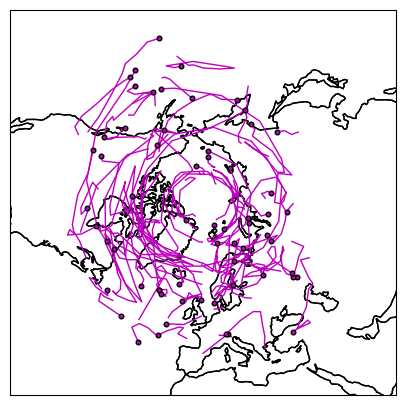

In [115]:
# plotting blocking track (center of mass) and genesis
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines

#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(block_df['Flag'][1000:2000])): #select blocking id
    lons = np.asarray(block_df['Longitude2'].iloc[np.where(block_df['Flag']==bid)])
    lats = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())